<a href="https://colab.research.google.com/github/Murcha1990/ML_AI25/blob/main/Hometasks/Pro/AI_HW1_Regression_with_inference_pro_pt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание №1 (pro). Часть 1**

В этом домашнем задании (его первой части) вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;


> Оценка за первую часть домашки = $min(\text{ваш балл}, 7)$



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [159]:
!pip install phik

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import itertools

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.model_selection import GridSearchCV
from phik import phik_matrix

random.seed(42)
np.random.seed(42)

### **Задание 0**
Давайте зафиксируем важный момент.

**Задание 0 (0 баллов).**
Изучите и ответье на вопрос: для чего фиксируем сиды в домашках?

> Чтобы результат, полученный в домашке, можно было воспроизвести (по сиду генерируется последовательность псевдослучайных чисел)

# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [161]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [ ] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [ ] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [ ] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [ ] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла).

In [162]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999 entries, 0 to 6998
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6999 non-null   object 
 1   year           6999 non-null   int64  
 2   selling_price  6999 non-null   int64  
 3   km_driven      6999 non-null   int64  
 4   fuel           6999 non-null   object 
 5   seller_type    6999 non-null   object 
 6   transmission   6999 non-null   object 
 7   owner          6999 non-null   object 
 8   mileage        6797 non-null   object 
 9   engine         6797 non-null   object 
 10  max_power      6803 non-null   object 
 11  torque         6796 non-null   object 
 12  seats          6797 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 711.0+ KB


> Пропуски есть в mileage, engine, max_power, torque, seats

In [163]:
df_train.duplicated().sum()

np.int64(985)

In [164]:
for i in range(0, len(df_train)):
  try:
    ffil_value = float(df_train.loc[i, 'max_power'][:-4])
    df_train.loc[i, 'max_power'] = ffil_value

  except:
    if df_train.loc[i, 'max_power'] in [np.nan, 'nan']:
      continue
    elif df_train.loc[i, 'max_power'] == '0':
      ffil_value = float(df_train.loc[i, 'max_power'])
      df_train.loc[i, 'max_power'] = ffil_value
    else:
      df_train.loc[i, 'max_power'] = 0


In [165]:
# !pip install ydata-profiling

In [166]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(df_train, title="Профайлинг")
# html = profile.to_html()

# with open('report.html', 'w') as file:
#   file.write(html)

# # profile.to_notebook_iframe()

> ### Выводы по дата-профайлингу:

- Есть 493 дубликата (около 7% всех строк), их нужно убрать
- Профайлер заметил высокую корреляцию между рядом признаков, надо будет что-то с этим сделать
- Большинство колонок текстовые / категориальные, нужно будет их перекодировать
- mileage представлен как текст, но по факту это числовой признак. Нужно будет его перевести в численный вид. Аналогично с torque.
- Признак engine имеет 120 уникальных значений, с ним нужно будет что-то придумать (вероятно цифры до "СС" имеют какой-то числовой смысл)
- Признак seller_type несбалансированный, стоит это учесть при работе с ним
- Признак max_power числовой, но представлен не в числовом виде


### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [ ] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?
- [ ] Сделайте выводы по статистикам. Отсутсвие выводов равносильно по баллам невыполнению задания.

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

In [167]:
df_train.describe()

,year,selling_price,km_driven,seats
count,6999.000000,6.999000e+03,6.999000e+03,6797.000000
mean,2013.818403,6.395152e+05,6.958462e+04,5.419008
std,4.053095,8.089419e+05,5.772400e+04,0.965767
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.700000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


In [168]:
df_test.describe()

,year,selling_price,km_driven,seats
count,1000.000000,1.000000e+03,1000.000000,981.000000
mean,2013.681000,6.179010e+05,71393.341000,5.410805
std,4.012149,7.585539e+05,48486.218662,0.919985
min,1995.000000,3.100000e+04,1303.000000,4.000000
25%,2011.000000,2.500000e+05,37000.000000,5.000000
50%,2014.000000,4.349990e+05,61500.000000,5.000000
75%,2017.000000,6.700000e+05,100000.000000,5.000000
max,2020.000000,6.000000e+06,375000.000000,9.000000


In [169]:
df_train.describe(include=['object'])

,name,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque
count,6999,6999,6999,6999,6999,6797,6797,6803.0,6796
unique,1924,4,3,2,5,386,120,313.0,419
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner,18.9 kmpl,1248 CC,74.0,190Nm@ 2000rpm
freq,116,3793,5826,6095,4587,197,885,330.0,468


In [170]:
df_test.describe(include=['object'])

,name,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque
count,1000,1000,1000,1000,1000,981,981,981,981
unique,621,4,3,2,5,237,88,182,226
top,Maruti Alto 800 LXI,Diesel,Individual,Manual,First Owner,18.6 kmpl,1248 CC,74 bhp,200Nm@ 1750rpm
freq,15,534,837,877,623,23,116,43,57


In [171]:
num_cols_train = df_train.select_dtypes(include=['number']).columns
num_cols_test = df_test.select_dtypes(include=['number']).columns

compare = pd.DataFrame({
    'train_mean': df_train.describe().loc['mean'],
    'test_mean': df_test.describe().loc['mean'],
    'train_median': df_train[num_cols_train].median(),
    'test_median': df_test[num_cols_test].median()
})
compare

,train_mean,test_mean,train_median,test_median
year,2013.818403,2013.681000,2015.0,2014.0
selling_price,639515.197171,617901.042000,450000.0,434999.0
km_driven,69584.615517,71393.341000,60000.0,61500.0
seats,5.419008,5.410805,5.0,5.0


> Среднее и медиана на трейне и тесте отличаются незначительно (2-3%) - свидетельствует о том, что выборки сделаны случайным и независим способом

### Выводы

- mileage, engine, torque, max_power необходимо аккуратно перевести в численный формат (слишком много уникальных значений)
- name также имеет очень много значений, с ним нужно будет что-то придумать
- остальные категориальные признаки легко можно будет перекодировать, тк уникальных значений немного
- основные статистики на трейне и тесте мало отличаются, разбиение можно считать случайным и независимым
- нет ни одной машины менее, чем с двумя сиденьями :)

### **Задание 3 (0.2 балла)**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.01 балла)
- [ ] Отобразите такие объекты (0.01 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.01 балла)
- [ ]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.01 балла)
- [ ] Подумайте, могут ли в данных быть другие скрытые дубли? Предложите, как их можно отлавливать. (0.16 балла)

P.S тут данные без подвоха, но выводы нам нужны.

In [172]:
features = df_train.drop(columns='selling_price', axis=1).columns
df_train[features].duplicated().sum()

np.int64(1159)

> Есть 1159 дублирующихся строки

In [173]:
df_train[df_train[features].duplicated()]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
254,Hyundai Grand i10 Sportz,2017,450000,35000,Petrol,Individual,Manual,First Owner,18.9 kmpl,1197 CC,82.0,114Nm@ 4000rpm,5.0
258,Maruti Swift VXI,2012,330000,50000,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,85.8,114Nm@ 4000rpm,5.0
268,Maruti Swift Dzire VXI,2014,400000,70000,Petrol,Individual,Manual,Second Owner,19.1 kmpl,1197 CC,85.8,114Nm@ 4000rpm,5.0
324,Jaguar XE 2016-2019 2.0L Diesel Prestige,2017,2625000,9000,Diesel,Dealer,Automatic,First Owner,13.6 kmpl,1999 CC,177.0,430Nm@ 1750-2500rpm,5.0
325,Lexus ES 300h,2019,5150000,20000,Petrol,Dealer,Automatic,First Owner,22.37 kmpl,2487 CC,214.56,202Nm@ 3600-5200rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6947,Chevrolet Spark 1.0 LS,2010,140000,60000,Petrol,Individual,Manual,Second Owner,18.0 kmpl,995 CC,62.0,90.3Nm@ 4200rpm,5.0
6984,Ford Freestyle Titanium Plus Diesel BSIV,2018,746000,24000,Diesel,Individual,Manual,First Owner,24.4 kmpl,1498 CC,98.63,215Nm@ 1750-3000rpm,5.0
6989,Maruti Swift Dzire VDI,2015,625000,50000,Diesel,Individual,Manual,First Owner,26.59 kmpl,1248 CC,74.0,190Nm@ 2000rpm,5.0
6997,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70.0,140Nm@ 1800-3000rpm,5.0


In [174]:
df_train = df = df_train.drop_duplicates(subset=features, keep='first')
df_train = df.reset_index(drop=True)
df_train

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74.0,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90.0,22.4 kgm at 1750-2750rpm,5.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2,"11.5@ 4,500(kgm@ rpm)",5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86,113.75nm@ 4000rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,Hyundai Santro Xing GLS,2008,120000,191000,Petrol,Individual,Manual,First Owner,17.92 kmpl,1086 CC,62.1,96.1Nm@ 3000rpm,5.0
5836,Maruti Wagon R VXI BS IV with ABS,2013,260000,50000,Petrol,Individual,Manual,Second Owner,18.9 kmpl,998 CC,67.1,90Nm@ 3500rpm,5.0
5837,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85,113.7Nm@ 4000rpm,5.0
5838,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.8 kmpl,1493 CC,110.0,"24@ 1,900-2,750(kgm@ rpm)",5.0


In [175]:
assert df_train.shape == (5840, 13)

### Скрытые дубли
> Также можно привести к нижнему регистру и убрать пробелы в столбце name

In [176]:
df_train['name_normalized'] = df_train['name'].str.lower().str.strip()

In [177]:
df_train['name'].nunique()

1924

In [178]:
df_train['name_normalized'].nunique()

1909

In [179]:
features = df_train.drop(columns=['selling_price', 'name'], axis=1).columns
df_train[features].duplicated().sum()

np.int64(0)

In [180]:
df_train = df_train.drop(columns='name_normalized', axis=1)

> Новых дублей не нашли :(

> Также в теории можно поискать почти полные дубли (где в одном из вариантов пропущено 1-2 признака, поэтому он не ловится через .duplicated())

> Или обратить внимание на столбец torque, который записан странным образом.

### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

In [181]:
strange_features = ['mileage', 'engine', 'max_power', 'torque']
df_train[strange_features]

,mileage,engine,max_power,torque
0,23.4 kmpl,1248 CC,74.0,190Nm@ 2000rpm
1,21.14 kmpl,1498 CC,103.52,250Nm@ 1500-2500rpm
2,23.0 kmpl,1396 CC,90.0,22.4 kgm at 1750-2750rpm
3,16.1 kmpl,1298 CC,88.2,"11.5@ 4,500(kgm@ rpm)"
4,20.14 kmpl,1197 CC,81.86,113.75nm@ 4000rpm
...,...,...,...,...
5835,17.92 kmpl,1086 CC,62.1,96.1Nm@ 3000rpm
5836,18.9 kmpl,998 CC,67.1,90Nm@ 3500rpm
5837,18.5 kmpl,1197 CC,82.85,113.7Nm@ 4000rpm
5838,16.8 kmpl,1493 CC,110.0,"24@ 1,900-2,750(kgm@ rpm)"


> Пофиксим mileage

In [182]:
df_train['mileage'] = df_train['mileage'].apply(lambda x: x.split()[0] if pd.notna(x) else None)
df_train['mileage'] = df_train['mileage'].astype(float)
df_train['mileage'].head()

,mileage
0,23.40
1,21.14
2,23.00
3,16.10
4,20.14


In [183]:
df_test['mileage'] = df_test['mileage'].apply(lambda x: x.split()[0] if pd.notna(x) else None)
df_test['mileage'] = df_test['mileage'].astype(float)
df_test['mileage'].head()

,mileage
0,14.0
1,21.5
2,12.9
3,25.1
4,16.5


> Пофиксим engine

In [184]:
df_train['engine'] = df_train['engine'].apply(lambda x: x.split()[0] if pd.notna(x) else None)
df_train['engine'] = df_train['engine'].astype(float)
df_train['engine'].head()

,engine
0,1248.0
1,1498.0
2,1396.0
3,1298.0
4,1197.0


In [185]:
df_test['engine'] = df_test['engine'].apply(lambda x: x.split()[0] if pd.notna(x) else None)
df_test['engine'] = df_test['engine'].astype(float)
df_test['engine'].head()

,engine
0,2498.0
1,1497.0
2,1799.0
3,1498.0
4,1172.0


> Пофиксим max_power

In [186]:
df_train['max_power'] = df_train['max_power'].astype(float)
df_train['max_power'].head()

,max_power
0,74.00
1,103.52
2,90.00
3,88.20
4,81.86


In [187]:
df_test['max_power'] = df_test['max_power'].apply(lambda x: x.split()[0] if pd.notna(x) else None)
df_test['max_power'] = df_test['max_power'].astype(float)
df_test['max_power'].head()

,max_power
0,112.0
1,108.5
2,130.0
3,98.6
4,65.0


> Пофиксим torque

> Принцип работы функции: Функция извлекает из текстовой строки два числовых значения: крутящий момент (в Nm или kgm, конвертируя kgm в Nm умножением на 9.80665) и обороты двигателя (rpm, усредняя если указан диапазон)

In [188]:
import re

def parse_torque(torque_str): # код написан с помощью Claude-Sonnet
    """
    Парсит строку torque и возвращает значение крутящего момента и обороты
    """
    if pd.isna(torque_str) or torque_str == '':
        return None, None

    torque_str = torque_str.lower()

    torque_value = None
    torque_match = re.search(r'([\d.]+)\s*(?:nm|kgm)', torque_str)
    if torque_match:
        torque_value = float(torque_match.group(1))
        if 'kgm' in torque_str:
            torque_value = torque_value * 9.80665

    rpm_value = None
    rpm_match = re.search(r'[@at\s]+([\d,]+)(?:[-~]+([\d,]+))?\s*(?:\(?\s*(?:rpm|kgm)?)?', torque_str)
    if rpm_match:
        rpm1 = float(rpm_match.group(1).replace(',', ''))
        if rpm_match.group(2):
            rpm2 = float(rpm_match.group(2).replace(',', ''))
            rpm_value = (rpm1 + rpm2) / 2
        else:
            rpm_value = rpm1

    return torque_value, rpm_value

In [189]:
df_train[['torque', 'max_torque_rpm']] = df_train['torque'].apply(
    lambda x: pd.Series(parse_torque(x))
)
df_train['torque'].head()

,torque
0,190.00000
1,250.00000
2,219.66896
3,NaN
4,113.75000


In [190]:
df_test[['torque', 'max_torque_rpm']] = df_test['torque'].apply(
    lambda x: pd.Series(parse_torque(x))
)
df_test['torque'].head()

,torque
0,260.0
1,260.0
2,172.0
3,200.0
4,96.0


In [191]:
df_train[strange_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mileage    5654 non-null   float64
 1   engine     5654 non-null   float64
 2   max_power  5657 non-null   float64
 3   torque     5321 non-null   float64
dtypes: float64(4)
memory usage: 182.6 KB


> Страшные признаки перекодированы

### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [ ] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [ ] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - По тренировочным данным для `train` и `test` - **верное**






> Посмотрим еще раз, в каких столбцах есть пропуски

In [192]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            5840 non-null   object 
 1   year            5840 non-null   int64  
 2   selling_price   5840 non-null   int64  
 3   km_driven       5840 non-null   int64  
 4   fuel            5840 non-null   object 
 5   seller_type     5840 non-null   object 
 6   transmission    5840 non-null   object 
 7   owner           5840 non-null   object 
 8   mileage         5654 non-null   float64
 9   engine          5654 non-null   float64
 10  max_power       5657 non-null   float64
 11  torque          5321 non-null   float64
 12  seats           5654 non-null   float64
 13  max_torque_rpm  5649 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 638.9+ KB


In [193]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1000 non-null   object 
 1   year            1000 non-null   int64  
 2   selling_price   1000 non-null   int64  
 3   km_driven       1000 non-null   int64  
 4   fuel            1000 non-null   object 
 5   seller_type     1000 non-null   object 
 6   transmission    1000 non-null   object 
 7   owner           1000 non-null   object 
 8   mileage         981 non-null    float64
 9   engine          981 non-null    float64
 10  max_power       981 non-null    float64
 11  torque          934 non-null    float64
 12  seats           981 non-null    float64
 13  max_torque_rpm  977 non-null    float64
dtypes: float64(6), int64(3), object(5)
memory usage: 109.5+ KB


In [194]:
features_to_fill = ['mileage', 'engine', 'max_power', 'torque',
                    'seats', 'max_torque_rpm']

> До заполнения пропусков:

In [195]:
df_train_old = df_train.copy()
df_train[features_to_fill].describe()

,mileage,engine,max_power,torque,seats,max_torque_rpm
count,5654.000000,5654.000000,5657.000000,5321.000000,5654.00000,5649.000000
mean,19.432842,1435.418111,88.087496,172.931597,5.44075,2864.536290
std,4.051002,492.453262,32.150448,99.241691,0.99527,986.517813
min,0.000000,624.000000,0.000000,47.071920,2.00000,1300.000000
25%,16.800000,1197.000000,68.000000,110.000000,5.00000,2000.000000
50%,19.370000,1248.000000,81.860000,160.000000,5.00000,2400.000000
75%,22.320000,1498.000000,100.000000,204.000000,5.00000,4000.000000
max,42.000000,3604.000000,400.000000,3726.527000,14.00000,21800.000000


До заполнения пропусков:

In [196]:
df_test_old = df_test.copy()
df_test[features_to_fill].describe()

,mileage,engine,max_power,torque,seats,max_torque_rpm
count,981.000000,981.000000,981.000000,934.000000,981.000000,977.000000
mean,19.338206,1458.882773,91.015627,175.908902,5.410805,2907.257932
std,3.989872,526.228560,35.207383,90.881059,0.919985,963.217353
min,0.000000,624.000000,34.200000,48.000000,4.000000,1470.000000
25%,16.500000,1197.000000,69.000000,110.000000,5.000000,2125.000000
50%,19.330000,1248.000000,83.100000,171.300000,5.000000,2500.000000
75%,22.320000,1582.000000,102.000000,214.500000,5.000000,4000.000000
max,32.260000,3604.000000,280.000000,620.000000,9.000000,5000.000000


> Видим, что у torque, max_power и max_torque_rpm есть выбросы (max во много раз больше mean) - поэтому стоит использовать именно медиану, а не среднее для заполнения пропусков

In [197]:
medians = {}
for col in features_to_fill:
    medians[col] = df_train[col].median()

for col in features_to_fill:
    df_train[col] = df_train[col].fillna(medians[col])
    df_test[col] = df_test[col].fillna(medians[col])

После заполнения:

In [198]:
df_train[features_to_fill].describe()

,mileage,engine,max_power,torque,seats,max_torque_rpm
count,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,19.430841,1429.448973,87.892354,171.782368,5.426712,2849.343408
std,3.985973,485.662834,31.661223,94.799972,0.982344,973.760953
min,0.000000,624.000000,0.000000,47.071920,2.000000,1300.000000
25%,16.950000,1197.000000,68.000000,112.000000,5.000000,2000.000000
50%,19.370000,1248.000000,81.860000,160.000000,5.000000,2400.000000
75%,22.300000,1498.000000,99.000000,200.000000,5.000000,3750.000000
max,42.000000,3604.000000,400.000000,3726.527000,14.000000,21800.000000


После заполнения:

In [199]:
df_test[features_to_fill].describe()

,mileage,engine,max_power,torque,seats,max_torque_rpm
count,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,19.33881,1454.87600,90.841670,174.858914,5.403000,2895.591000
std,3.95175,521.99574,34.893389,87.916553,0.912921,955.099475
min,0.00000,624.00000,34.200000,48.000000,4.000000,1470.000000
25%,16.55000,1197.00000,69.000000,111.795810,5.000000,2125.000000
50%,19.37000,1248.00000,82.425000,160.000000,5.000000,2400.000000
75%,22.30000,1582.00000,102.000000,205.000000,5.000000,4000.000000
max,32.26000,3604.00000,280.000000,620.000000,9.000000,5000.000000


> Описательные статистики практически не изменились

> Убедимся, что пропусков не осталось

In [200]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            5840 non-null   object 
 1   year            5840 non-null   int64  
 2   selling_price   5840 non-null   int64  
 3   km_driven       5840 non-null   int64  
 4   fuel            5840 non-null   object 
 5   seller_type     5840 non-null   object 
 6   transmission    5840 non-null   object 
 7   owner           5840 non-null   object 
 8   mileage         5840 non-null   float64
 9   engine          5840 non-null   float64
 10  max_power       5840 non-null   float64
 11  torque          5840 non-null   float64
 12  seats           5840 non-null   float64
 13  max_torque_rpm  5840 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 638.9+ KB


In [201]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1000 non-null   object 
 1   year            1000 non-null   int64  
 2   selling_price   1000 non-null   int64  
 3   km_driven       1000 non-null   int64  
 4   fuel            1000 non-null   object 
 5   seller_type     1000 non-null   object 
 6   transmission    1000 non-null   object 
 7   owner           1000 non-null   object 
 8   mileage         1000 non-null   float64
 9   engine          1000 non-null   float64
 10  max_power       1000 non-null   float64
 11  torque          1000 non-null   float64
 12  seats           1000 non-null   float64
 13  max_torque_rpm  1000 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 109.5+ KB


> Считать медиану правильно для train и test именно по трейну - иначе может случиться утечка данных в тест, что не очень хорошо

### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.
- [ ] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [202]:
df_train['seats'] = df_train['seats'].astype(int)
df_train['engine'] = df_train['engine'].astype(int)

In [203]:
df_train['seats'].value_counts()

,count
seats,
5,4618
7,800
8,191
4,94
9,68
6,48
10,18
2,2
14,1


> В теории seats можно рассматривать как категориальную переменную, тк там ограниченное кол-во значений, плюс его числовой смысл не такой явный

> Можно рассматривать автомобили с n сидениями как определенную категорию.

### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [ ] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [204]:
df_train.describe()

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
count,5840.000000,5.840000e+03,5.840000e+03,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,2013.428425,5.229601e+05,7.395224e+04,19.430841,1429.448973,87.892354,171.782368,5.426712,2849.343408
std,4.095622,5.354320e+05,6.007114e+04,3.985973,485.662834,31.661223,94.799972,0.982344,973.760953
min,1983.000000,2.999900e+04,1.000000e+00,0.000000,624.000000,0.000000,47.071920,2.000000,1300.000000
25%,2011.000000,2.500000e+05,3.900000e+04,16.950000,1197.000000,68.000000,112.000000,5.000000,2000.000000
50%,2014.000000,4.050000e+05,7.000000e+04,19.370000,1248.000000,81.860000,160.000000,5.000000,2400.000000
75%,2017.000000,6.400000e+05,1.000000e+05,22.300000,1498.000000,99.000000,200.000000,5.000000,3750.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.000000,3604.000000,400.000000,3726.527000,14.000000,21800.000000


In [205]:
df_test.describe()

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
count,1000.000000,1.000000e+03,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2013.681000,6.179010e+05,71393.341000,19.33881,1454.87600,90.841670,174.858914,5.403000,2895.591000
std,4.012149,7.585539e+05,48486.218662,3.95175,521.99574,34.893389,87.916553,0.912921,955.099475
min,1995.000000,3.100000e+04,1303.000000,0.00000,624.00000,34.200000,48.000000,4.000000,1470.000000
25%,2011.000000,2.500000e+05,37000.000000,16.55000,1197.00000,69.000000,111.795810,5.000000,2125.000000
50%,2014.000000,4.349990e+05,61500.000000,19.37000,1248.00000,82.425000,160.000000,5.000000,2400.000000
75%,2017.000000,6.700000e+05,100000.000000,22.30000,1582.00000,102.000000,205.000000,5.000000,4000.000000
max,2020.000000,6.000000e+06,375000.000000,32.26000,3604.00000,280.000000,620.000000,9.000000,5000.000000


In [206]:
delta_train = df_train.describe() - df_train_old.describe()
delta_train

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
count,0.0,0.0,0.0,186.000000,186.000000,183.000000,519.000000,186.000000,191.000000
mean,0.0,0.0,0.0,-0.002001,-5.969138,-0.195142,-1.149229,-0.014038,-15.192882
std,0.0,0.0,0.0,-0.065029,-6.790429,-0.489225,-4.441719,-0.012926,-12.756860
min,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.150000,0.000000,0.000000,2.000000,0.000000,0.000000
50%,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.0,0.0,-0.020000,0.000000,-1.000000,-4.000000,0.000000,-250.000000
max,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


> Как можно заметить, статистики изменились очень слабо - нет оснований предполагать, что распределения заметно изменились. Разве что снизилась дисперсия, тк мы добавили "центральных" наблюдений.

> В теории это могло произойти - если бы пропусков было больше, мы бы снизили дисперсию еще сильнее и изменение распределений было бы заметно.

## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [ ] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [ ] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [ ] Постройте pairplot по тестовым данным
- [ ] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

In [207]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            5840 non-null   object 
 1   year            5840 non-null   int64  
 2   selling_price   5840 non-null   int64  
 3   km_driven       5840 non-null   int64  
 4   fuel            5840 non-null   object 
 5   seller_type     5840 non-null   object 
 6   transmission    5840 non-null   object 
 7   owner           5840 non-null   object 
 8   mileage         5840 non-null   float64
 9   engine          5840 non-null   int64  
 10  max_power       5840 non-null   float64
 11  torque          5840 non-null   float64
 12  seats           5840 non-null   int64  
 13  max_torque_rpm  5840 non-null   float64
dtypes: float64(4), int64(5), object(5)
memory usage: 638.9+ KB


In [208]:
num_cols = df_train.select_dtypes(include=['int64', 'float64']).columns
num_cols

Index(['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power',
       'torque', 'seats', 'max_torque_rpm'],
      dtype='object')

<Figure size 1200x1000 with 0 Axes>

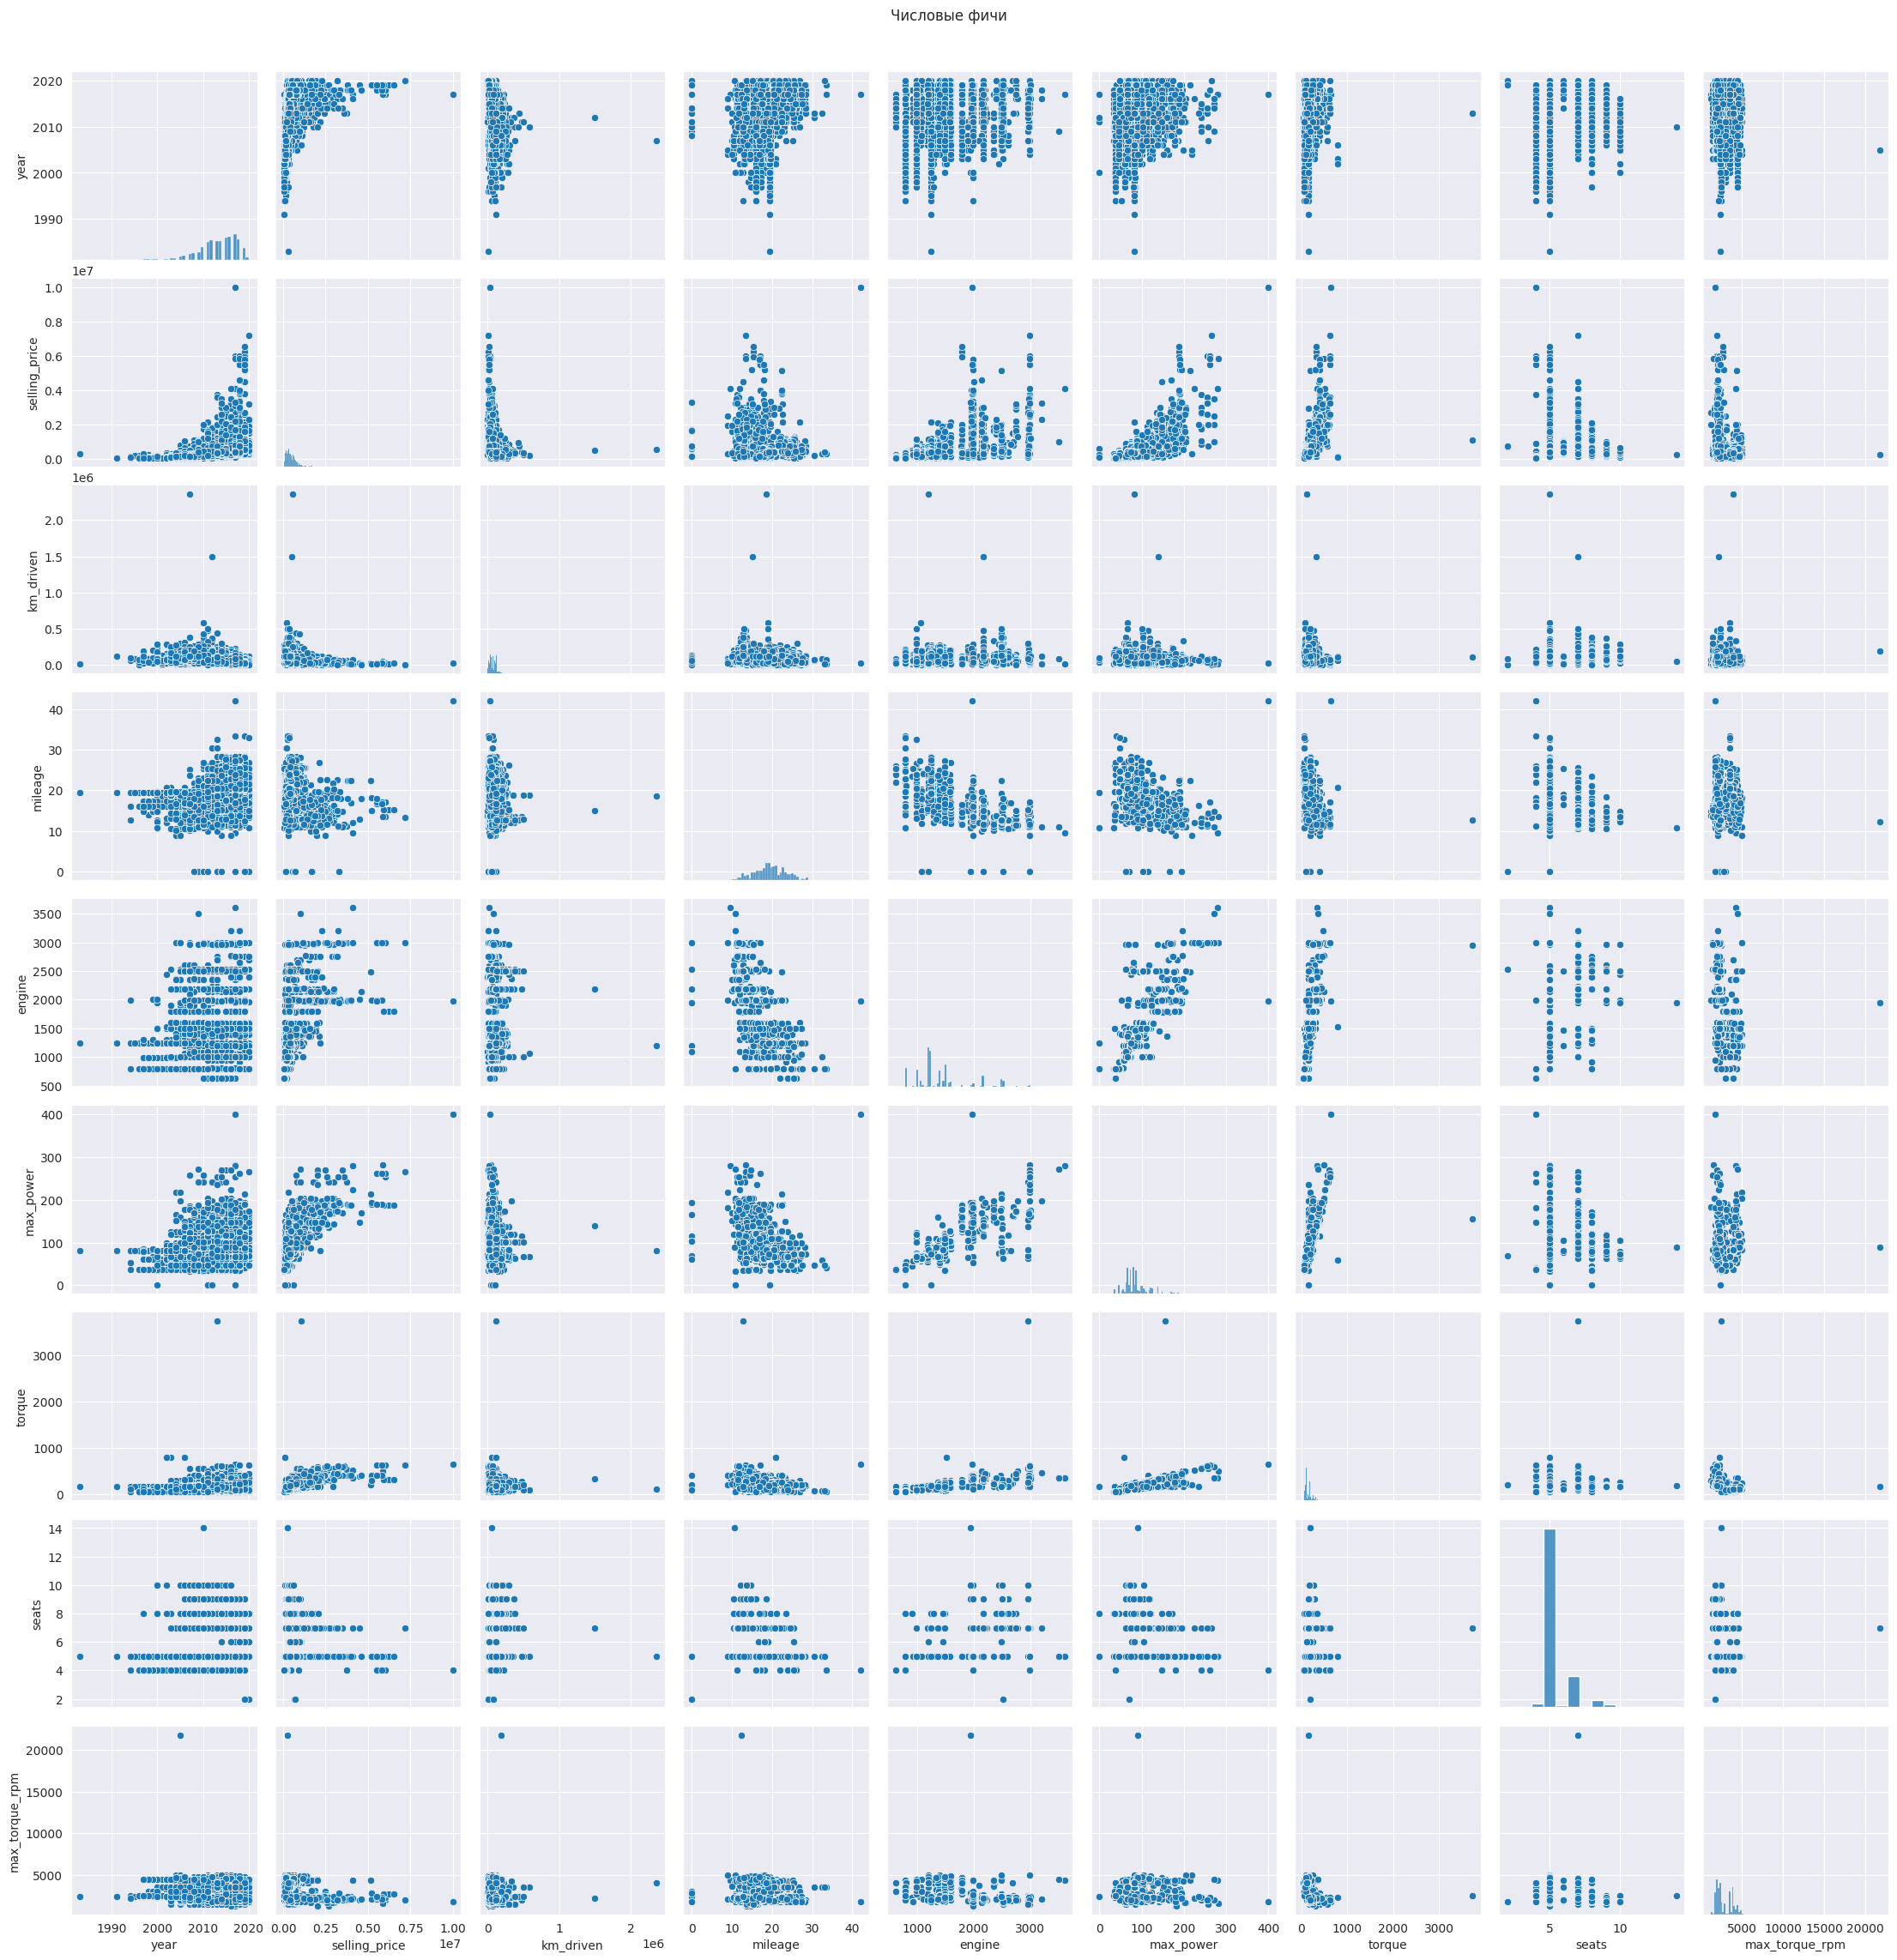

In [209]:
plt.figure(figsize=(12, 10))
sns.set_style("darkgrid")

sns.pairplot(df_train[num_cols])
plt.suptitle('Числовые фичи', y=1.02)
plt.show()

> Относительно четко проглядывается зависимость selling_price от year, km_driven, engine, max_power. Влияние остальных признаков на таргет менее очевидно по визуализации

> Что касается признаков, визуализация говорит о наличии потенциальной связи между engine и max_power, torque и max_power, mileage и engine (в профайлинге был алерт о корреляции между year и km_driven, но я его глазами не особо вижу)

<Figure size 1200x1000 with 0 Axes>

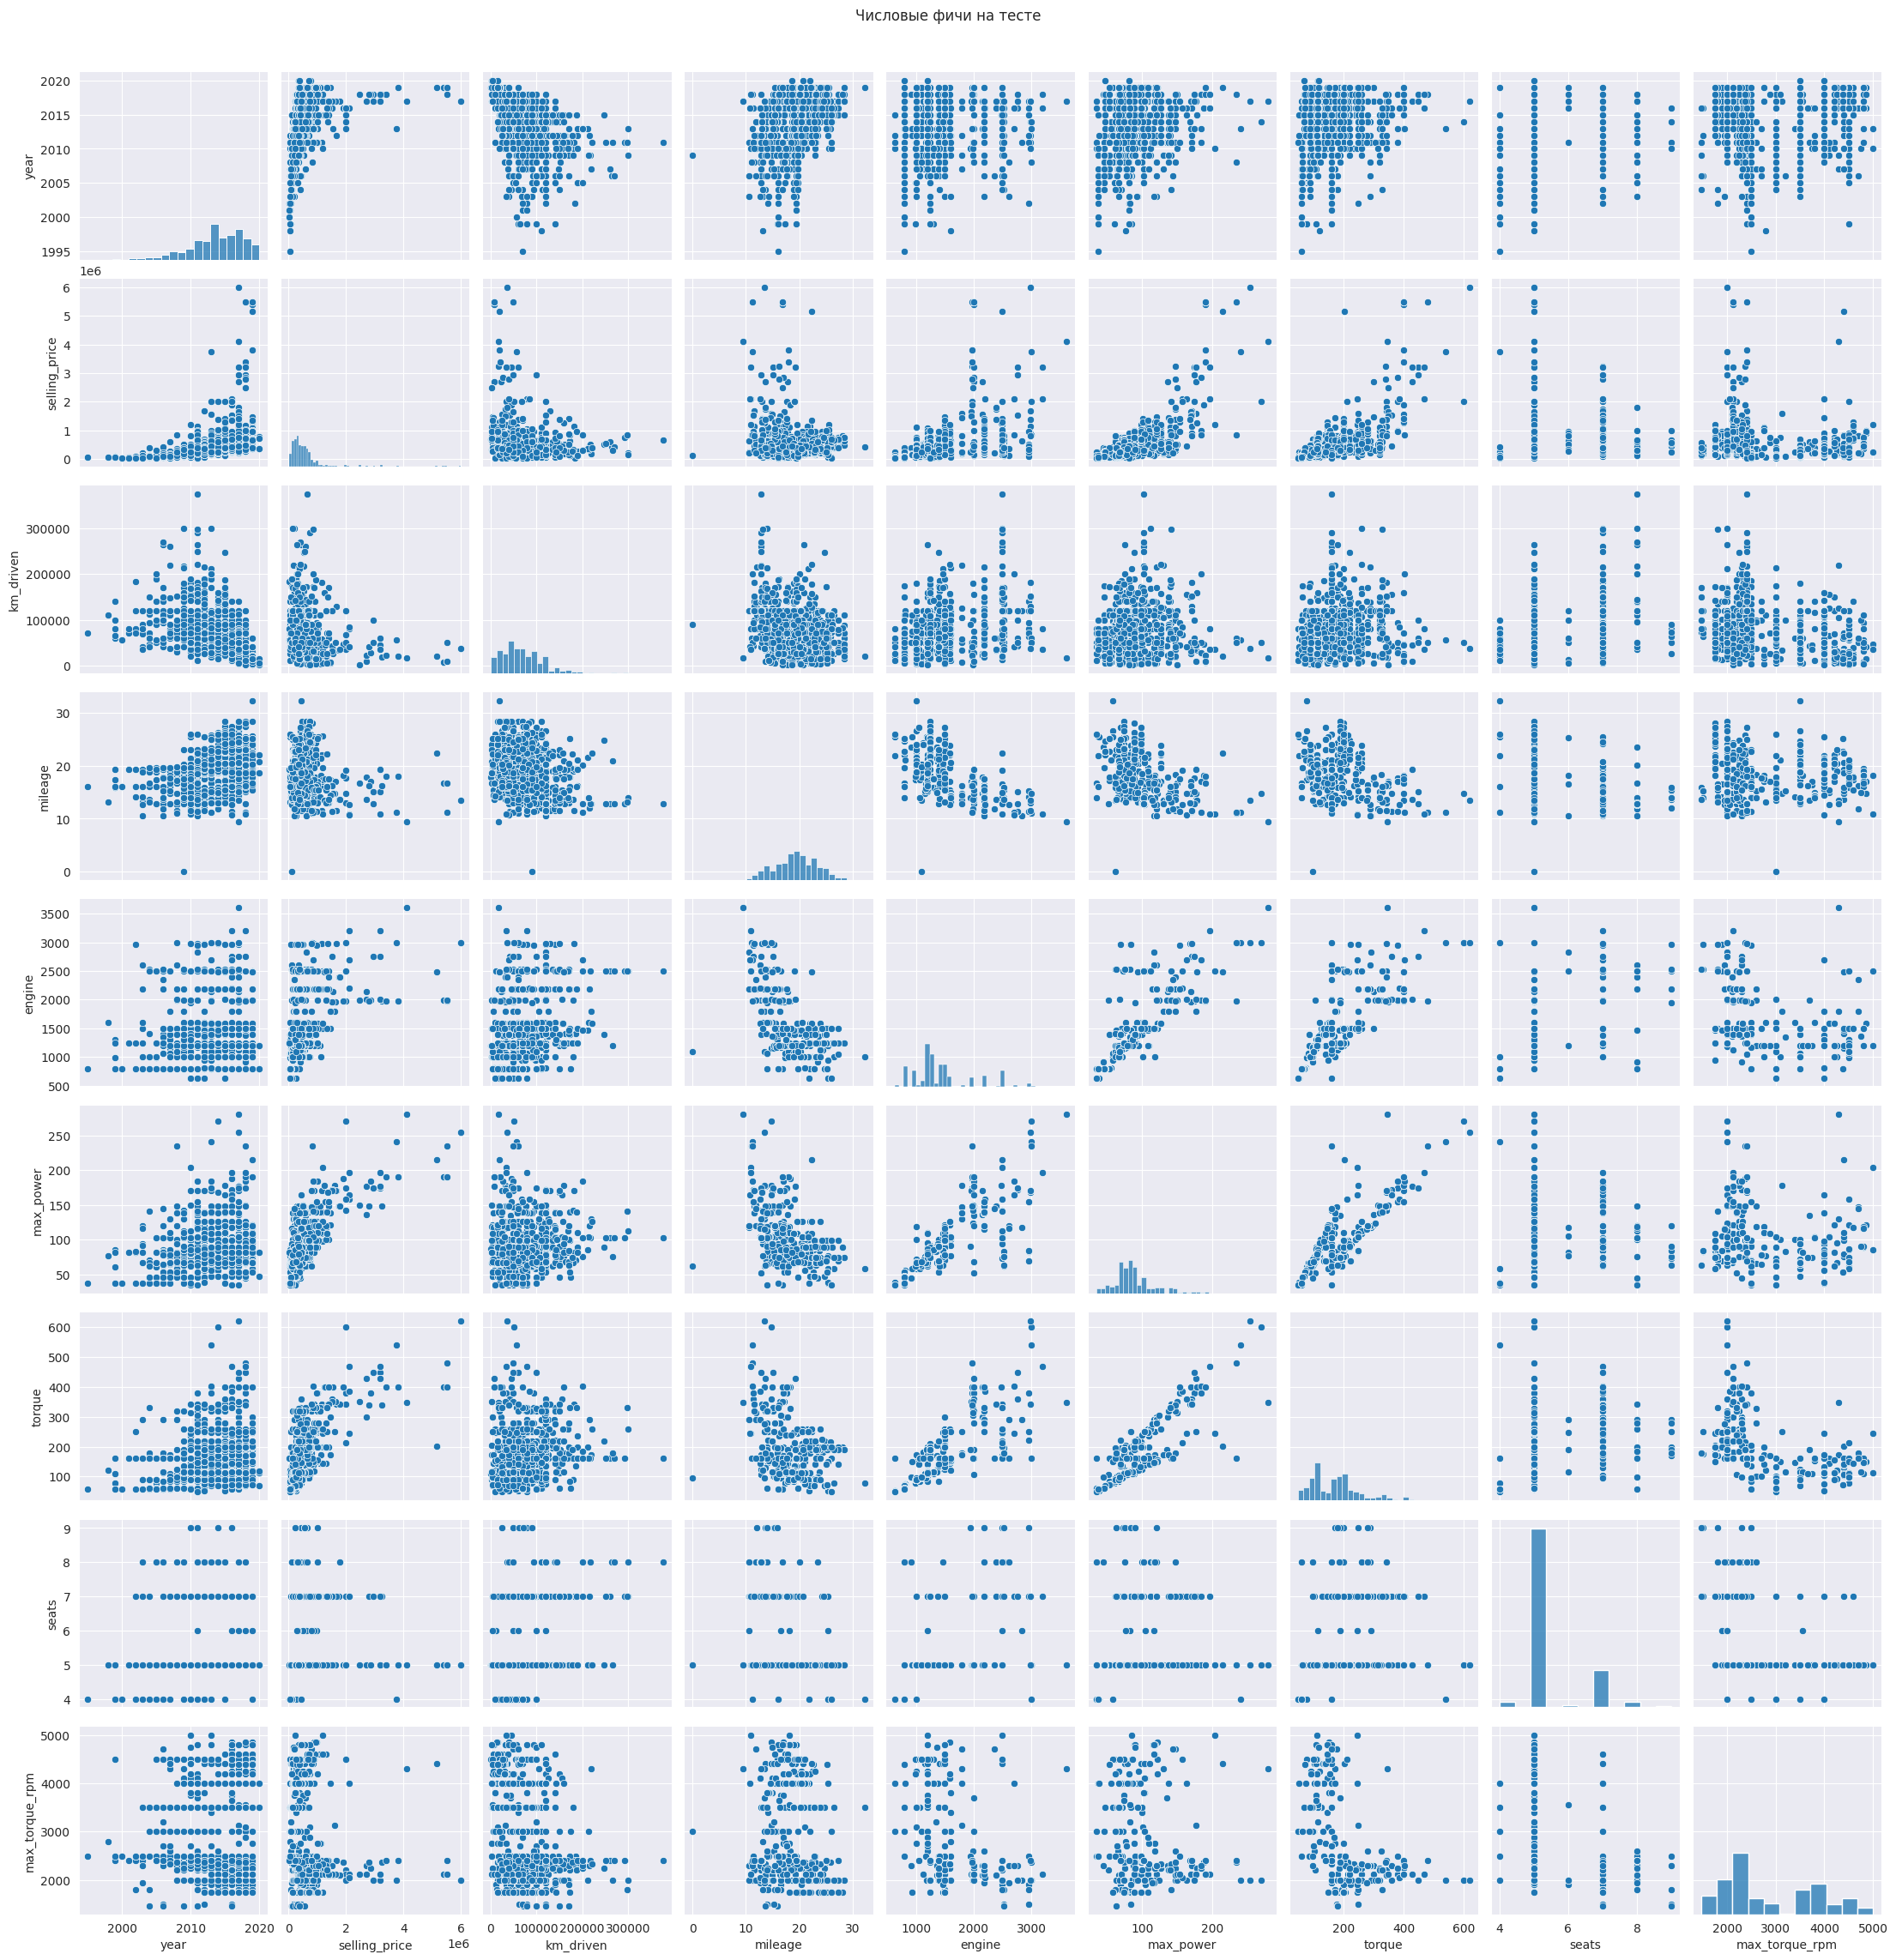

In [210]:
plt.figure(figsize=(12, 10))
sns.set_style("darkgrid")

sns.pairplot(df_test[num_cols])
plt.suptitle('Числовые фичи на тесте', y=1.02)
plt.show()

> На первый взгляд почти все распределения совпадают, но по-видимому на тесте больше выбросов, что меняет отображение распределение на пэйплоте

> Плюс заметно иначе выглядит распределения с torque на тесте

### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [ ] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [ ] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

In [211]:
corr_matrix = df_train[num_cols].corr(method='pearson')
corr_matrix

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
year,1.000000,0.427279,-0.368966,0.341334,0.002819,0.158207,0.113381,0.041178,0.032672
selling_price,0.427279,1.000000,-0.164828,-0.104769,0.447672,0.692725,0.546542,0.149953,-0.177739
km_driven,-0.368966,-0.164828,1.000000,-0.182086,0.229766,0.024379,0.111236,0.192328,-0.232477
mileage,0.341334,-0.104769,-0.182086,1.000000,-0.572893,-0.372197,-0.214322,-0.451059,-0.090976
engine,0.002819,0.447672,0.229766,-0.572893,1.000000,0.681247,0.647979,0.652172,-0.385368
max_power,0.158207,0.692725,0.024379,-0.372197,0.681247,1.000000,0.727571,0.242791,-0.155754
torque,0.113381,0.546542,0.111236,-0.214322,0.647979,0.727571,1.000000,0.324907,-0.489047
seats,0.041178,0.149953,0.192328,-0.451059,0.652172,0.242791,0.324907,1.000000,-0.297367
max_torque_rpm,0.032672,-0.177739,-0.232477,-0.090976,-0.385368,-0.155754,-0.489047,-0.297367,1.000000


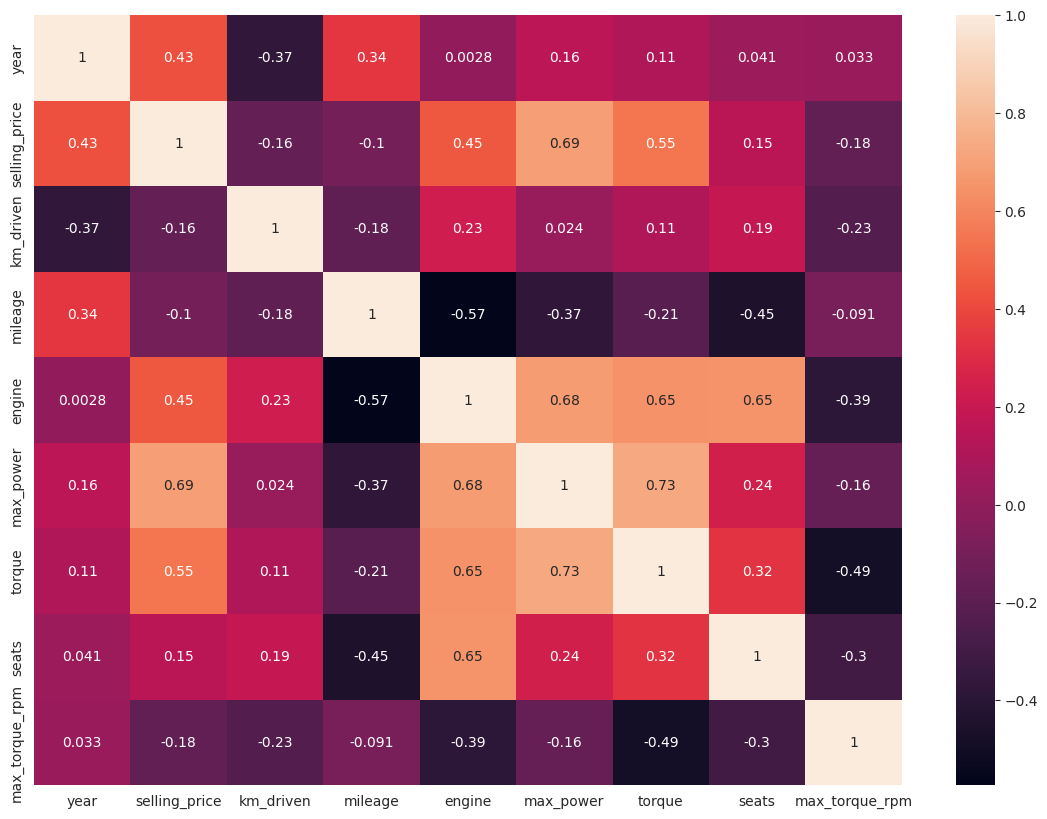

In [212]:
plt.figure(figsize=(14, 10))

sns.heatmap(corr_matrix, annot=True)
plt.show()

- [ ] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?
 - Изучите типы корреляций в `pd.corr()`. Какую вы использовали по умолчанию?

Какие 2 признака наименее скоррелированы между собой?

> year и engine (0,0028)

Между какими наблюдается довольно сильная положительная линейная зависимость?

> year, engine, max_power, torque и selling_price (предположения из визуализаций подтвердились)
> engine, torque и max_power
> engine и seats
> seats и torque

Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?

> year и km_driven обладают заметной отрицательной корреляцией, так что да

 Изучите типы корреляций в `pd.corr()`. Какую вы использовали по умолчанию?

 > По умолчанию там 'pearson', но я её прописывал явно

### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [ ] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией
- [ ] Сделайте выводы


Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [ ] Проинтерпретируйте результаты


In [213]:
def spearman_corr(X: pd.DataFrame) -> pd.DataFrame:
  corr_matrix = pd.DataFrame(data=np.zeros((X.shape[1], X.shape[1])),
                         columns=X.columns,
                         index=X.columns)
  X_ranks = X.copy()
  for col in X.columns:
    X_ranks[col] = X[col].rank()

  n = len(X)
  for i in range(len(X_ranks.columns)):
    for j in range(i, len(X_ranks.columns)):
      corr = 1 - 6 * ((X_ranks.iloc[:, i] - X_ranks.iloc[:, j]) ** 2).sum() / (n * (n**2 - 1))
      corr_matrix.iloc[i, j] = corr_matrix.iloc[j, i] = corr

  return corr_matrix

In [214]:
corr_spearman = spearman_corr(df_train[num_cols])
corr_spearman

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
year,1.000000,0.708146,-0.563074,0.348408,-0.031368,0.169264,0.121166,0.286074,0.009592
selling_price,0.708146,1.000000,-0.294527,0.026349,0.465252,0.612708,0.578083,0.473845,-0.253055
km_driven,-0.563074,-0.294527,1.000000,-0.197444,0.307153,0.041580,0.237267,0.387720,-0.305662
mileage,0.348408,0.026349,-0.197444,1.000000,-0.425435,-0.307907,-0.128812,-0.060193,-0.149716
engine,-0.031368,0.465252,0.307153,-0.425435,1.000000,0.714353,0.820187,0.624671,-0.464033
max_power,0.169264,0.612708,0.041580,-0.307907,0.714353,1.000000,0.745973,0.464333,-0.149487
torque,0.121166,0.578083,0.237267,-0.128812,0.820187,0.745973,1.000000,0.547068,-0.667856
seats,0.286074,0.473845,0.387720,-0.060193,0.624671,0.464333,0.547068,1.000000,0.029173
max_torque_rpm,0.009592,-0.253055,-0.305662,-0.149716,-0.464033,-0.149487,-0.667856,0.029173,1.000000


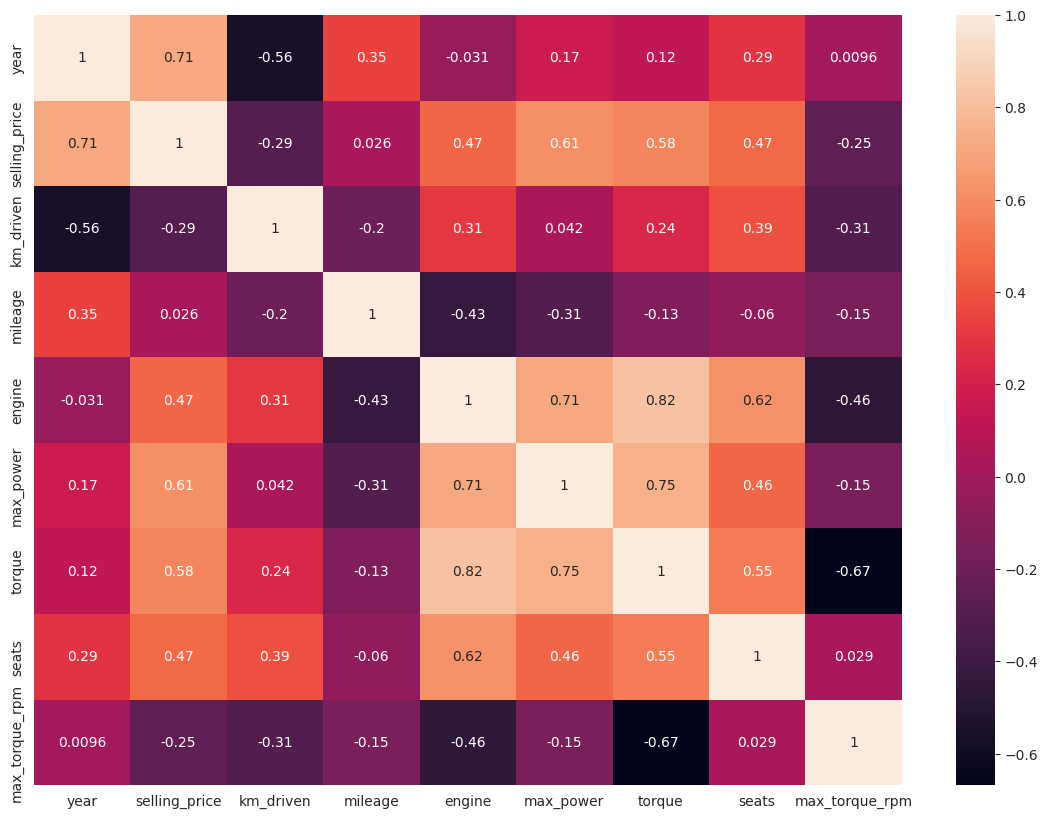

In [215]:
plt.figure(figsize=(14, 10))

sns.heatmap(corr_spearman, annot=True)
plt.show()

> Различия матриц корреляций Пирсона и Спирмена:

- Спирмен показывает более сильную связь year и selling_price (0.71 > 0.43)
- mileage и selling_price по Спирмену почти независимы, хотя по Пирсону есть небольшая отрицательная корреляция - возможно, из-за выбросов
- Спирмен показывает более сильную связь engine и torque (0.82 > 0.65)
- При этом есть пара selling_price - engine, где обе корреляции схожи

> Вывод: в большистве пар корреляции схожи, но в отдельных различаются из-за возможных выбросов или нелинейной связи. Кардинальных противоречий нет.

Построим phik

interval columns not set, guessing: ['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm']


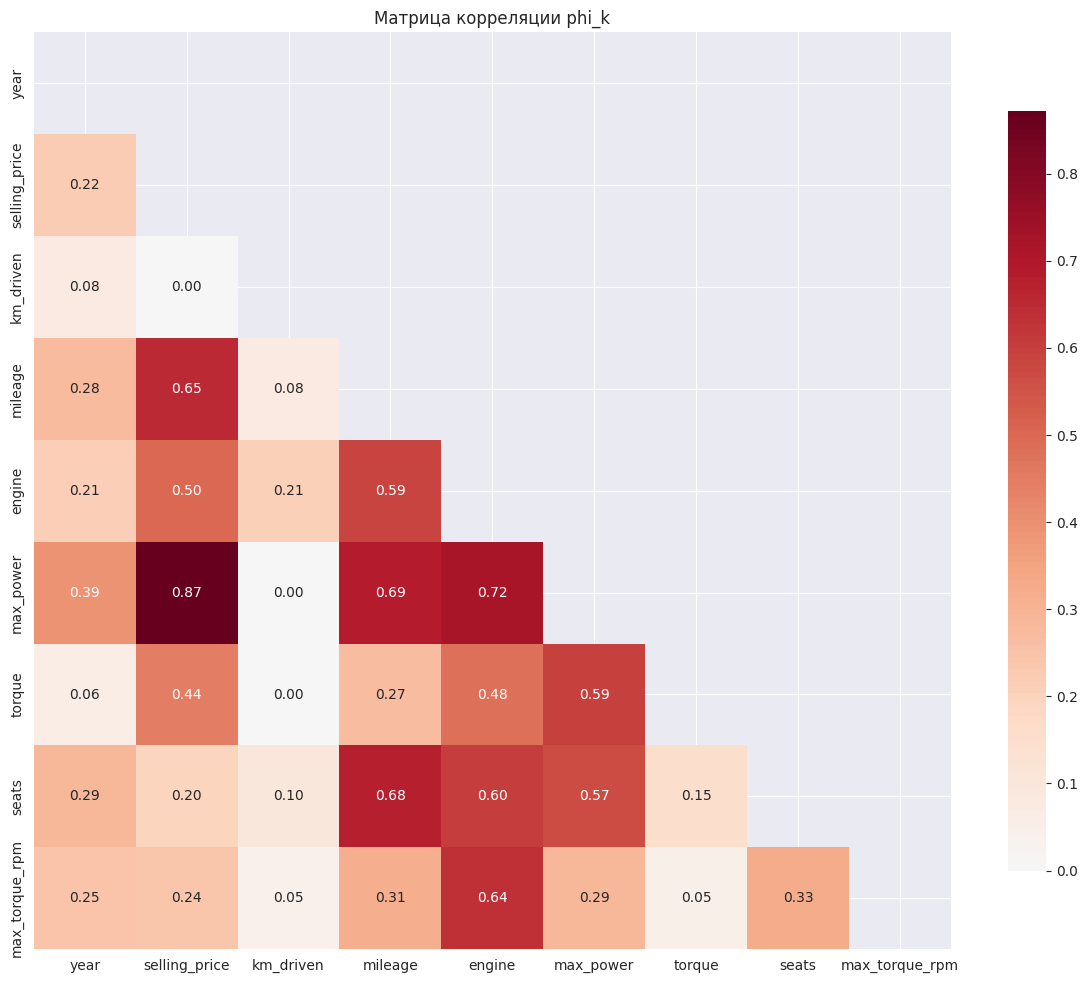

In [216]:
corr_phik = phik_matrix(df_train[num_cols])

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_phik, dtype=bool))
sns.heatmap(corr_phik,
            mask=mask,
            annot=True,
            fmt='.2f',
            cmap='RdBu_r',
            center=0,
            square=True,
            cbar_kws={'shrink': 0.8})
plt.title('Матрица корреляции phi_k')
plt.tight_layout()
plt.show()

Какие выводы можно сделать:

- сильное влияние на цену оказывает max_power, engine, seats
- km_driven и year неожиданно слабо влияет на цену
- по аналогии со сделанными ранее визуализациями видим зависимость engine, max_power, torque


### **Дополнительные визуализации (бонус 0.25 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.
Один график: 0.125 балла, при условии, что он обоснован.

>  В визуализациях мы не проверяли наличие выбросов

> График 1: боксплоты для числовых признаков

In [217]:
cols_to_check = [col for col in num_cols if col != 'year'] # в году судя по min_val = 1985 выбросов нет

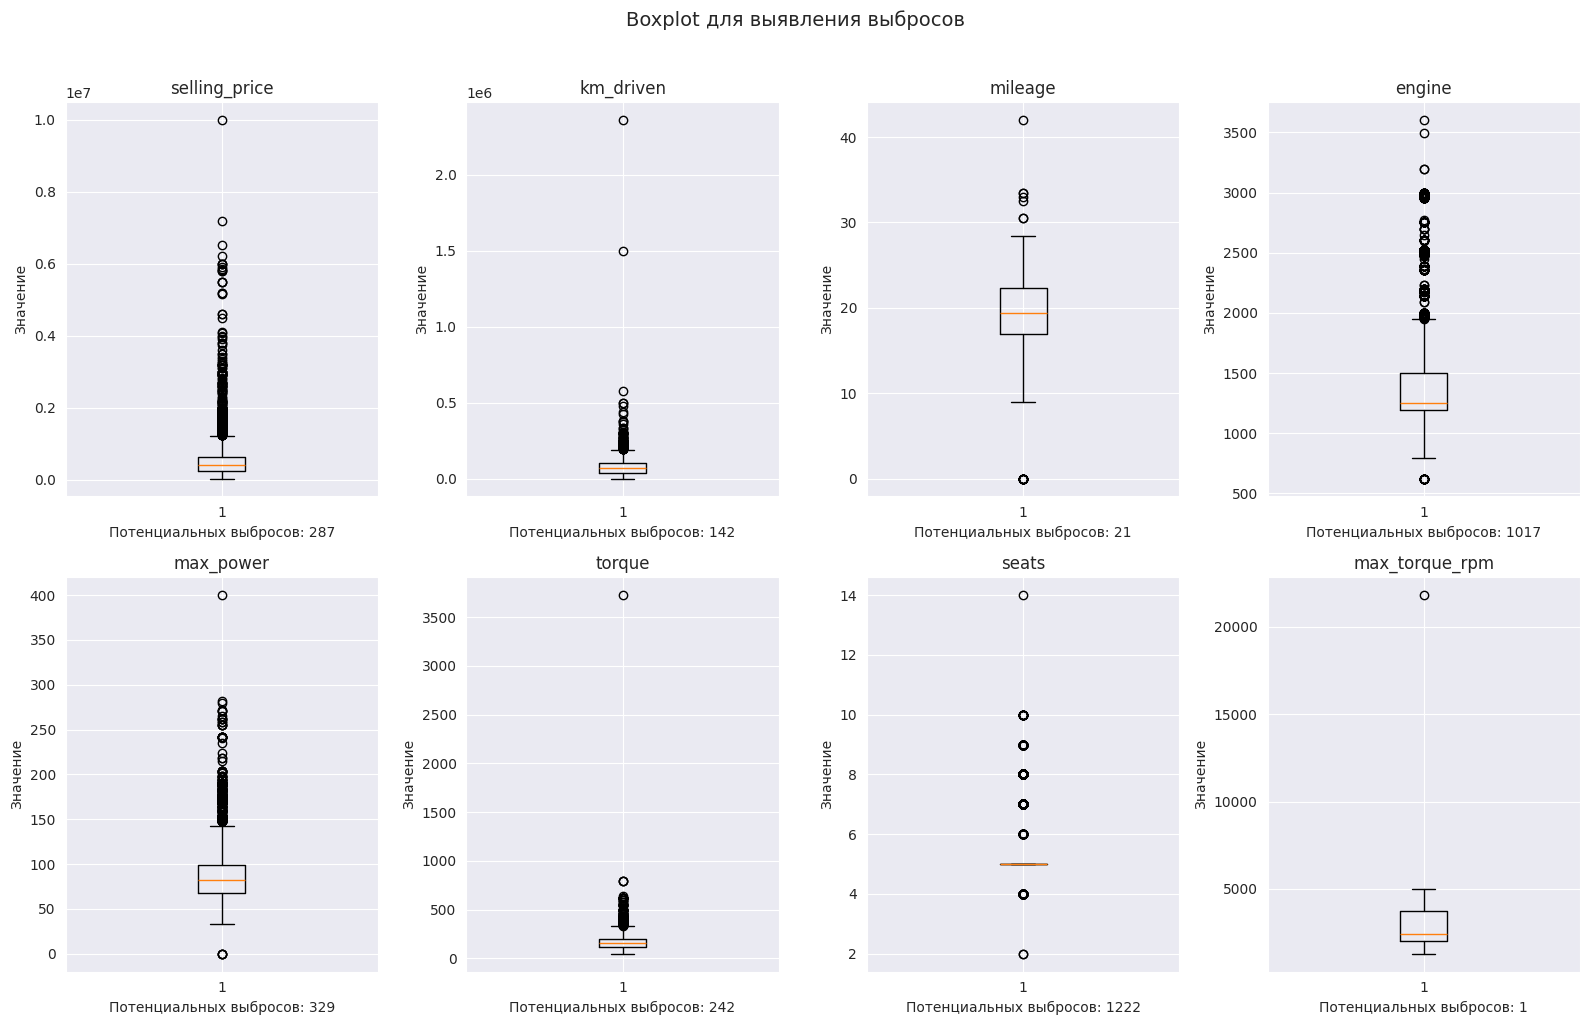

In [218]:
# в построении красивого боксплота мне помог Claude

fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(cols_to_check):
    axes[i].boxplot(df_train[col].dropna(), vert=True)
    axes[i].set_title(f'{col}')
    axes[i].set_ylabel('Значение')

    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df_train[col] < Q1 - 1.5*IQR) | (df_train[col] > Q3 + 1.5*IQR)).sum()
    axes[i].set_xlabel(f'Потенциальных выбросов: {outliers}')

plt.suptitle('Boxplot для выявления выбросов', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

> График 2: поподробнее посмотрим на распределение таргета

> Построим гистограмму таргета и его логарифма

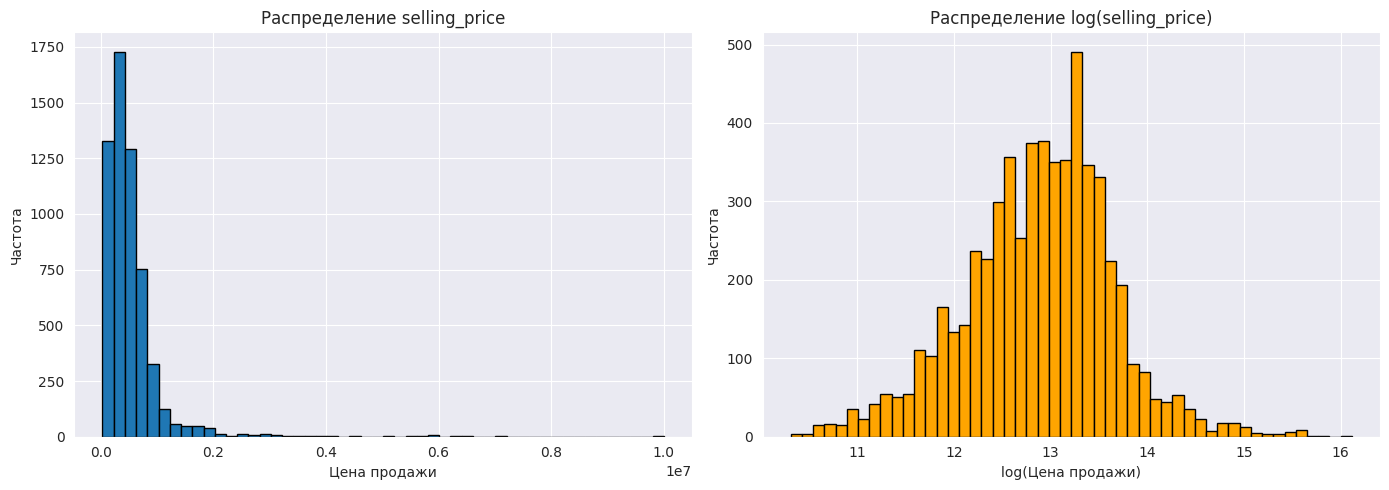

In [219]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_train['selling_price'], bins=50, edgecolor='black')
axes[0].set_xlabel('Цена продажи')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение selling_price')

axes[1].hist(np.log1p(df_train['selling_price']), bins=50, edgecolor='black', color='orange')
axes[1].set_xlabel('log(Цена продажи)')
axes[1].set_ylabel('Частота')
axes[1].set_title('Распределение log(selling_price)')

plt.tight_layout()
plt.show()

# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Разбейте данные на тренировочный и тестовый наборы. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных.

In [220]:
num_cols = [col for col in num_cols if col != 'selling_price']

In [221]:
y_train = df_train['selling_price'].copy()
X_train = df_train[num_cols].copy()

In [222]:
X_train.shape

(5840, 8)

In [223]:
y_test = df_test['selling_price'].copy()
X_test = df_test[num_cols].copy()

### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [224]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE

linreg = LinearRegression()

linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
y_pred_train = linreg.predict(X_train)

In [225]:
r2_train = r2_score(y_train, y_pred_train)
mse_train = MSE(y_train, y_pred_train)

print(f'Метрики на тесте:\n\nR^2 = {r2_train}, MSE = {mse_train}')

Метрики на тесте:

R^2 = 0.6011267197832995, MSE = 114332374256.6747


In [226]:
r2_test = r2_score(y_test, y_pred)
mse_test = MSE(y_test, y_pred)

print(f'Метрики на тесте:\n\nR^2 = {r2_test}, MSE = {mse_test}')

Метрики на тесте:

R^2 = 0.5994278697090265, MSE = 230260299084.17505


> MSE на тесте в 2 раза хуже, чем на трейне

> R^2 почти такой же

> Можем сделать вывод, что модель не очень хорошо работает на тестовых данных, возможно переобучилась

### **Задание 13 (0.15 балла)**

- [ ] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

In [227]:
def r2_custom(y_true: pd.Series, y_pred: pd.Series) -> float:
    mean = y_true.mean()
    y_mean = pd.Series([mean for _ in range(len(y_true))])

    RSS = ((y_true - y_pred) ** 2).sum()
    TSS = ((y_true - y_mean) ** 2).sum()

    return float(1 - RSS / TSS)

In [228]:
r2_custom(y_test, y_pred)

0.5994278697090265

> Формула R^2 = 1 - RSS/TSS, где RSS - сумма квадратов остатков, TSS - общая сумма квадратов

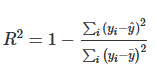

### **Бонус (0.15 балла)**

- [ ] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [ ] Объясните, когда применяется $\text{adjusted}-R^2$?

In [229]:
def r2_adjusted_custom(y_true: pd.Series, y_pred: pd.Series, k: int) -> float:
    n = len(y_true)

    mean = y_true.mean()
    y_mean = pd.Series([mean for _ in range(len(y_true))])

    RSS = ((y_true - y_pred) ** 2).sum()
    TSS = ((y_true - y_mean) ** 2).sum()

    r2_adjusted = 1 - (RSS / (n - k - 1)) / (TSS / (n - 1))

    return float(r2_adjusted)

In [230]:
r2_adjusted_custom(y_test, y_pred, 8)

0.5961941895452245

> R2 adjusted штрафует модель за большое количество признаков. Чем больше k, тем меньше значение.

> Если обычный коэффициент детерминации можно улучшать просто добавляя новые признаки (даже если они почти не значимы, R2 улучшится), то с R^2 adj такое не прокатит. Он улучшится, только если добавленный признак действительно вносит вклад в объясняющую способность модели.

### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [231]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


In [232]:
X_train_scaled.describe()

,year,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
count,5.840000e+03,5.840000e+03,5.840000e+03,5.840000e+03,5.840000e+03,5.840000e+03,5.840000e+03,5.840000e+03
mean,2.328122e-14,-6.205082e-17,-9.283290e-16,-1.301851e-16,-6.144248e-17,-2.847038e-16,2.640202e-16,-9.733462e-18
std,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00
min,-7.430137e+00,-1.231167e+00,-4.875222e+00,-1.658595e+00,-2.776263e+00,-1.315624e+00,-3.488601e+00,-1.591228e+00
25%,-5.929826e-01,-5.818974e-01,-6.224460e-01,-4.786631e-01,-6.283414e-01,-6.306699e-01,-4.344190e-01,-8.723046e-01
50%,1.395696e-01,-6.579834e-02,-1.526502e-02,-3.736430e-01,-1.905444e-01,-1.242973e-01,-4.344190e-01,-4.614910e-01
75%,8.721218e-01,4.336523e-01,7.198756e-01,1.411615e-01,3.508581e-01,2.976799e-01,-4.344190e-01,9.250050e-01
max,1.604674e+00,3.806654e+01,5.662630e+00,4.477875e+00,9.858570e+00,3.750053e+01,8.728126e+00,1.946297e+01


In [233]:
linreg.fit(X_train_scaled, y_train)

y_pred = linreg.predict(X_test_scaled)
y_pred_train = linreg.predict(X_train_scaled)

In [234]:
r2_train = r2_score(y_train, y_pred_train)
mse_train = MSE(y_train, y_pred_train)

print(f'Метрики на трейне:\n\nR^2 = {r2_train}, MSE = {mse_train}')

Метрики на трейне:

R^2 = 0.6011267197832995, MSE = 114332374256.6747


In [235]:
y_train.describe()

,selling_price
count,5.840000e+03
mean,5.229601e+05
std,5.354320e+05
min,2.999900e+04
25%,2.500000e+05
50%,4.050000e+05
75%,6.400000e+05
max,1.000000e+07


In [236]:
r2_test = r2_score(y_test, y_pred)
mse_test = MSE(y_test, y_pred)

print(f'Метрики на тесте:\n\nR^2 = {r2_test}, MSE = {mse_test}')

Метрики на тесте:

R^2 = 0.5994278697090274, MSE = 230260299084.17456


> Результаты не сильно изменились

### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [ ] Какой признак оказался наиболее информативным в предсказании цены?

In [237]:
linreg.coef_

array([164815.91558354, -50029.60811443, -10656.77563331,  14583.71614777,
       316967.93183408,  18896.39102397, -31639.38076408, -58321.95460306])

In [238]:
features = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': abs(linreg.coef_)
})
features.sort_values('coefficient', ascending=False)

,feature,coefficient
4,max_power,316967.931834
0,year,164815.915584
7,max_torque_rpm,58321.954603
1,km_driven,50029.608114
6,seats,31639.380764
5,torque,18896.391024
3,engine,14583.716148
2,mileage,10656.775633


> Самым важным признаком с этой точки зрения является max_power

### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [239]:
from sklearn.linear_model import Lasso

L1 = Lasso()

L1.fit(X_train_scaled, y_train)
y_pred_lasso = L1.predict(X_test_scaled)
y_pred_train_lasso = L1.predict(X_train_scaled)

In [240]:
lasso_r2_train = r2_score(y_train, y_pred_train_lasso)
lasso_mse_train = MSE(y_train, y_pred_train_lasso)

print(f'Метрики на трейне:\n\nR^2 = {lasso_r2_train}, MSE = {lasso_mse_train}')

Метрики на трейне:

R^2 = 0.6011267197361856, MSE = 114332374270.17935


In [241]:
lasso_r2_test = r2_score(y_test, y_pred_lasso)
lasso_mse_test = MSE(y_test, y_pred_lasso)

print(f'Метрики на тесте:\n\nR^2 = {lasso_r2_test}, MSE = {lasso_mse_test}')

Метрики на тесте:

R^2 = 0.5994265924595945, MSE = 230261033283.62125


> Метрики модели практически не изменились

In [242]:
L1.coef_

array([164813.67012211, -50028.67738068, -10653.384676  ,  14581.93267536,
       316969.13975739,  18896.37162538, -31635.37866369, -58319.67491762])

> Веса почти не изменились. Вероятно, из-за того, что L1-регуляризация склонна занулять малозначимые коэффициенты, близкие к нулю.
> В нашей модели похоже все коэффициенты значимы, либо мы взяли неверный alpha

### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [ ] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [243]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

params = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 250.0, 300.0, 350.0, 400.0, 500.0],
    'selection': ['cyclic', 'random'],
    'max_iter': [1000, 2000, 5000],
    'tol': [1e-4, 1e-3, 1e-2]
}

lasso_grid = GridSearchCV(
    estimator=Lasso(),
    param_grid=params,
    cv=10,
    scoring='neg_mean_squared_error'
)

lasso_grid.fit(X_train_scaled, y_train)

print("Гиперпараметры:", lasso_grid.best_params_)
print("Лучшее MSE:", -lasso_grid.best_score_)

Гиперпараметры: {'alpha': 400.0, 'max_iter': 2000, 'selection': 'random', 'tol': 0.01}
Лучшее MSE: 120229909912.70041


In [244]:
lasso_linreg = lasso_grid.best_estimator_

y_pred_lasso = lasso_linreg.predict(X_test_scaled)

In [245]:
lasso_r2_test = r2_score(y_test, y_pred_lasso)
lasso_mse_test = MSE(y_test, y_pred_lasso)

print(f'Метрики на тесте:\n\nR^2 = {lasso_r2_test}, MSE = {lasso_mse_test}')

Метрики на тесте:

R^2 = 0.5989252283536529, MSE = 230549231688.4886


> Значение MSE сильно упало по сравнению с тестом без регуляризации

 Сколько грид-сёрчу пришлось обучать моделей?
 > 10 alpha х 2 selection x 3 max_iter х 3 tol x 10 фолдов = 1800 моделей


 Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый

 - alpha - коэффициент регуляризации (чем он больше, тем сильнее штраф за величину весов)
 - selection - алгоритм выбора признаков для обновления коэффициентов (интернет подсказал, что в подобных моделях используется Coordinate Descent)
 - max_iter - максимальное число итераций для сходимости алгоритма оптимизации
 - tol - критерий остановки (когда изменение весов между итерациями < tol, алгоритм прекращается)


In [246]:
lasso_grid.best_estimator_.coef_

array([163799.94452369, -49694.96021651,  -9007.67147714,  14872.16232523,
       316757.27520533,  19280.73813893, -30396.42678746, -57032.35513827])

 Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

 > alpha = 400.0, веса не занулились

**Ваша задача 2:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [ ] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [247]:
params = {
    'alpha': [100.0, 250.0, 300.0, 350.0, 400.0, 500.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'selection': ['cyclic', 'random'],
    'max_iter': [1000, 2000, 5000],
    'tol': [1e-4, 1e-3, 1e-2]
}

elastic_grid = GridSearchCV(
    estimator=ElasticNet(),
    param_grid=params,
    cv=10,
    scoring='neg_mean_squared_error'
)

elastic_grid.fit(X_train_scaled, y_train)

print("Гиперпараметры:", elastic_grid.best_params_)
print("Лучшее MSE:", -elastic_grid.best_score_)

Гиперпараметры: {'alpha': 350.0, 'l1_ratio': 1.0, 'max_iter': 1000, 'selection': 'random', 'tol': 0.01}
Лучшее MSE: 120244879159.92996


In [248]:
elastic_linreg = elastic_grid.best_estimator_
y_pred_elastic = elastic_linreg.predict(X_test_scaled)

In [249]:
elastic_r2_test = r2_score(y_test, y_pred_elastic)
elastic_mse_test = MSE(y_test, y_pred_elastic)

print(f'Метрики на тесте:\n\nR^2 = {elastic_r2_test}, MSE = {elastic_mse_test}')

Метрики на тесте:

R^2 = 0.5989640868177184, MSE = 230526894733.7155


Сколько грид-сёрчу пришлось обучать моделей?

6 × 6 × 2 × 3 × 3 х 10 = 6480 моделей

Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [250]:
print("Гиперпараметры:", elastic_grid.best_params_)

Гиперпараметры: {'alpha': 350.0, 'l1_ratio': 1.0, 'max_iter': 1000, 'selection': 'random', 'tol': 0.01}


### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [ ] Реализуйте модель с $L0$-регуляризаицей.
- [ ] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [ ] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



In [251]:
# В написании данной модели мне помог Claude Sonnet
def l0_regression(X_train, y_train, X_test, y_test, max_features):
    n_features = X_train.shape[1]

    best_mse = float('inf')
    best_features = None
    best_model = None

    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values

    for features in itertools.combinations(range(n_features), max_features):
        features = list(features)

        model = LinearRegression()
        model.fit(X_train[:, features], y_train)

        y_pred = model.predict(X_test[:, features])
        mse = MSE(y_test, y_pred)

        if mse < best_mse:
            best_mse = mse
            best_features = features
            best_model = model

    return best_model, best_features, best_mse

In [252]:
results = []

for k in range(1, X_train_scaled.shape[1]):
    model, features, mse = l0_regression(
        X_train_scaled, y_train,
        X_test_scaled, y_test,
        max_features=k
    )

    results.append({
        'max_features': k,
        'selected_features': features,
        'test_mse': mse,
        'coefficients': model.coef_
    })

    print(f"\nmax_features = {k}:")
    print(f"  Выбранные признаки: {features}")
    print(f"  Test MSE: {mse:.4f}")



max_features = 1:
  Выбранные признаки: [4]
  Test MSE: 280162938375.3755

max_features = 2:
  Выбранные признаки: [0, 4]
  Test MSE: 240858730443.9160

max_features = 3:
  Выбранные признаки: [0, 1, 4]
  Test MSE: 235514677497.3423

max_features = 4:
  Выбранные признаки: [0, 1, 4, 7]
  Test MSE: 233245354363.7309

max_features = 5:
  Выбранные признаки: [0, 1, 4, 6, 7]
  Test MSE: 230981254546.2769

max_features = 6:
  Выбранные признаки: [0, 1, 3, 4, 6, 7]
  Test MSE: 230569188864.4135

max_features = 7:
  Выбранные признаки: [0, 1, 3, 4, 5, 6, 7]
  Test MSE: 230368395314.0229


In [253]:
best_idx = np.argmin([r['test_mse'] for r in results])
best_idx

np.int64(6)

> MSE получился не очень, на уровне с обычной регрессией без регуляризации - можно сделать вывод, что незначимых числовых признаков у нас нет

# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



In [254]:
obj_cols = df_train.select_dtypes(include='object').columns
obj_cols = obj_cols.union(['seats'])
obj_cols

Index(['fuel', 'name', 'owner', 'seats', 'seller_type', 'transmission'], dtype='object')

In [255]:
X_train_cat = df_train[obj_cols].copy()

In [256]:
X_test_cat = df_test[obj_cols].copy()

### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [ ] Предобработайте столбец `name`, чтобы избежать его удаления

In [257]:
X_train_cat['name'].sample(7)

,name
5551,Toyota Fortuner 2.8 4WD AT BSIV
2125,Honda Amaze S i-Dtech
4036,Chevrolet Enjoy TCDi LTZ 7 Seater
4944,Ford Figo Petrol LXI
4765,Ford EcoSport 1.5 TDCi Titanium BSIV
3523,Honda Amaze VX i-DTEC
3474,Ford EcoSport 1.5 Diesel Titanium Plus BSIV


In [258]:
X_train_cat['name'].nunique()

1924

> Категорий и правда много, нужно как-то извлечь самую полезную инфу из столбца

> На первом месте всегда стоит марка машины, её можно вынести в отдельный признак

In [259]:
X_train_cat['brand'] = X_train_cat['name'].apply(lambda x: x.split()[0])
X_train_cat['brand'].nunique()

30

In [260]:
X_train_cat['brand'].value_counts()

,count
brand,
Maruti,1804
Hyundai,1058
Mahindra,611
Tata,534
Toyota,309
Ford,308
Honda,308
Chevrolet,188
Renault,171


> Чтобы в будущем не плодить лишние столбцы в OHE, все редкие марки свалим в категорию "Другое"

In [261]:
brand_counts = X_train_cat['brand'].value_counts()
rare_brands = brand_counts[brand_counts < 50].index

X_train_cat['brand'] = X_train_cat['brand'].replace(rare_brands, 'Другое')

In [262]:
X_train_cat['brand'].nunique()

13

In [263]:
X_train_cat = X_train_cat.drop(columns='name', axis=1)

In [264]:
# assert X_train_cat.shape == (5840, 11)

> Полдня просидел с перекодированием name, но так и не понял, как сгенерить 6 столбцов для выполнения ассерта

> Из адекватных способов придумал только взять название марки

> Мб надо было найти какой-то паттерн в названии, но я не смог :(

In [265]:
X_train_cat.describe(include='object')

,fuel,owner,seller_type,transmission,brand
count,5840,5840,5840,5840,5840
unique,4,5,3,2,13
top,Diesel,First Owner,Individual,Manual,Maruti
freq,3177,3603,5223,5336,1804


In [266]:
obj_cols = df_train.select_dtypes(include='object').columns
obj_cols = obj_cols.union(['seats'])
obj_cols

Index(['fuel', 'name', 'owner', 'seats', 'seller_type', 'transmission'], dtype='object')

Не забудем про X_test_cat

In [267]:
X_test_cat['brand'] = X_test_cat['name'].apply(lambda x: x.split()[0])
brand_counts = X_test_cat['brand'].value_counts()
rare_brands = brand_counts[brand_counts < 20].index

X_test_cat['brand'] = X_test_cat['brand'].replace(rare_brands, 'Другое')

In [268]:
X_test_cat = X_test_cat.drop(columns='name', axis=1)

### **Задание 20 (0.1 балла)**

- [ ] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

In [269]:
X_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   fuel          5840 non-null   object
 1   owner         5840 non-null   object
 2   seats         5840 non-null   int64 
 3   seller_type   5840 non-null   object
 4   transmission  5840 non-null   object
 5   brand         5840 non-null   object
dtypes: int64(1), object(5)
memory usage: 273.9+ KB


In [270]:
from sklearn.preprocessing import OneHotEncoder # или можно использовать get_dummies из библиотеки pandas

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_cat_encoded = ohe.fit_transform(X_train_cat)

feature_names = ohe.get_feature_names_out()

X_train_cat_encoded = pd.DataFrame(
    X_train_cat_encoded,
    columns=feature_names,
    index=X_train_cat.index
)

In [271]:
X_train_cat_encoded.head()

,fuel_CNG,fuel_Diesel,fuel_LPG,fuel_Petrol,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner,seats_2,...,brand_Hyundai,brand_Mahindra,brand_Maruti,brand_Nissan,brand_Renault,brand_Skoda,brand_Tata,brand_Toyota,brand_Volkswagen,brand_Другое
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [272]:
X_test_cat_encoded = pd.DataFrame(
    ohe.transform(X_test_cat),
    columns=feature_names,
    index=X_test_cat.index
)

In [273]:
X_test_cat_encoded.columns

Index(['fuel_CNG', 'fuel_Diesel', 'fuel_LPG', 'fuel_Petrol',
       'owner_First Owner', 'owner_Fourth & Above Owner', 'owner_Second Owner',
       'owner_Test Drive Car', 'owner_Third Owner', 'seats_2', 'seats_4',
       'seats_5', 'seats_6', 'seats_7', 'seats_8', 'seats_9', 'seats_10',
       'seats_14', 'seller_type_Dealer', 'seller_type_Individual',
       'seller_type_Trustmark Dealer', 'transmission_Automatic',
       'transmission_Manual', 'brand_Chevrolet', 'brand_Ford', 'brand_Honda',
       'brand_Hyundai', 'brand_Mahindra', 'brand_Maruti', 'brand_Nissan',
       'brand_Renault', 'brand_Skoda', 'brand_Tata', 'brand_Toyota',
       'brand_Volkswagen', 'brand_Другое'],
      dtype='object')

In [274]:
X_train_cat_encoded.shape

(5840, 36)

In [275]:
X_test_cat_encoded.shape

(1000, 36)

### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?

### Ответы

Как корректно работать с OHE преобразованием?

- обучать только на трейне, а на тесте лишь применять
- если категорий очень много, расплодим признаки и может быть плохо
- на тесте могут попаться категории, которых не было на трейне - при инициализации энкодера handle_unknown='ignore'

Почему мы удаляем один столбец?

> Чтобы не попасть в дамми ловушку и не создать мультиколлинеарность (когда столбцы в сумме дают единичный столбец)

Пусть из  n  признаков мы получили  n−1  столбец, из которых  k<n−1  оказались не важными по весам модели. Корректно ли их удалить?

> Нет, тк эти n-1 столбцов также кодируют и n-ный столбец, который пропущен по причине выше. Соответственно удаление n-1 незначимых столбцов лишает нас информации о пропущенном n-ном столбце и в совокупности группа этих столбцов может быть значима.

> Перед удалением стоит провести тест (например тест Фишера) сразу для всей группы столбцов и уже тогда судить об их значимости

### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [ ] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [ ] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

> Объединим все признаки в один датафрейм

In [276]:
X_train_combined = pd.concat([X_train_scaled, X_train_cat_encoded], axis=1)
X_train_combined = X_train_combined.drop(columns='seats')

print(f"Размер итогового датафрейма: {X_train_combined.shape}")

Размер итогового датафрейма: (5840, 43)


In [277]:
X_test_combined = pd.concat([X_test_scaled, X_test_cat_encoded], axis=1)
X_test_combined = X_test_combined.drop(columns='seats')

print(f"Размер итогового датафрейма: {X_test_combined.shape}")

Размер итогового датафрейма: (1000, 43)


In [278]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

params = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 250.0, 500.0, 1000.0]
}

ridge_grid = GridSearchCV(
    estimator=Ridge(),
    param_grid=params,
    cv=10,
    scoring='r2'
)

ridge_grid.fit(X_train_combined, y_train)

print("Лучшие гиперпараметры:", ridge_grid.best_params_)
print("Лучший R² на кросс-валидации:", ridge_grid.best_score_)

Лучшие гиперпараметры: {'alpha': 10.0}
Лучший R² на кросс-валидации: 0.6527675060729907


Посмотрим на метрики на тесте

In [279]:
ridge_linreg = ridge_grid.best_estimator_

y_pred_ridge = ridge_linreg.predict(X_test_combined)

In [280]:
ridge_r2_test = r2_score(y_test, y_pred_ridge)
ridge_mse_test = MSE(y_test, y_pred_ridge)


print(f'Метрики на тесте:\n\nR^2 = {ridge_r2_test}, MSE = {ridge_mse_test}')

Метрики на тесте:

R^2 = 0.6933814173949908, MSE = 176253116970.7445


> Чекнем результаты наших моделей

In [281]:
results_df = pd.DataFrame({
    'Model': ['Обычная регрессия', 'Lasso', 'ElasticNet', 'Ridge'],
    'R2_test': [r2_test, lasso_r2_test, elastic_r2_test, ridge_r2_test],
    'MSE_test': [mse_test, lasso_mse_test, elastic_mse_test, ridge_mse_test]
})
results_df

,Model,R2_test,MSE_test
0,Обычная регрессия,0.599428,2.302603e+11
1,Lasso,0.598925,2.305492e+11
2,ElasticNet,0.598964,2.305269e+11
3,Ridge,0.693381,1.762531e+11


> Ridge с категориальными признаками уверенно побеждает!

> Проверим остальные модели с категориальными фичами

In [282]:
def grid_search(model, params, scoring, name):
  grid = GridSearchCV(
      estimator=model,
      param_grid=params,
      cv=10,
      scoring=scoring
  )

  grid.fit(X_train_combined, y_train)

  print(f'\nРезультаты для {name}\n')

  print("Лучшие гиперпараметры:", grid.best_params_)
  print("Лучшая метрика на кросс-валидации:", grid.best_score_)

  return grid.best_estimator_

In [283]:
linreg_combined = grid_search(model=LinearRegression(),
                              params={},
                              scoring='r2',
                              name='Линейная регрессия')

# Ridge
ridge_combined = grid_search(model=Ridge(),
                            params={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
                            scoring='r2',
                            name='Ridge')

# Lasso
lasso_combined = grid_search(model=Lasso(max_iter=10000),
                            params={'alpha': [1000, 1500, 1750, 1790, 1800, 1850, 2000]},
                            scoring='r2',
                            name='Lasso')

# ElasticNet
elastic_combined = grid_search(model=ElasticNet(max_iter=10000),
                              params={
                                  'alpha': [0.01, 0.1, 1.0],
                                  'l1_ratio': [0.5, 0.6, 0.7, 0.9]
                              },
                              scoring='r2',
                              name='ElasticNEt')


Результаты для Линейная регрессия

Лучшие гиперпараметры: {}
Лучшая метрика на кросс-валидации: 0.6509736071752735

Результаты для Ridge

Лучшие гиперпараметры: {'alpha': 10.0}
Лучшая метрика на кросс-валидации: 0.6527675060729907

Результаты для Lasso

Лучшие гиперпараметры: {'alpha': 1850}
Лучшая метрика на кросс-валидации: 0.6580488059742653

Результаты для ElasticNEt

Лучшие гиперпараметры: {'alpha': 0.01, 'l1_ratio': 0.9}
Лучшая метрика на кросс-валидации: 0.6527121503166303


In [284]:
results = []

# Линейная регрессия
y_pred_linreg_combined = linreg_combined.predict(X_test_combined)
mse_linreg_combined = MSE(y_test, y_pred_linreg_combined)
r2_linreg_combined = r2_score(y_test, y_pred_linreg_combined)
results.append({
    'Модель': 'Линейная регрессия',
    'R²': r2_linreg_combined,
    'MSE': mse_linreg_combined
})

# Ridge
y_pred_ridge_combined = ridge_combined.predict(X_test_combined)
mse_ridge_combined = MSE(y_test, y_pred_ridge_combined)
r2_ridge_combined = r2_score(y_test, y_pred_ridge_combined)
results.append({
    'Модель': 'Ridge',
    'R²': r2_ridge_combined,
    'MSE': mse_ridge_combined
})

# Lasso
y_pred_lasso_combined = lasso_combined.predict(X_test_combined)
mse_lasso_combined = MSE(y_test, y_pred_lasso_combined)
r2_lasso_combined = r2_score(y_test, y_pred_lasso_combined)
results.append({
    'Модель': 'Lasso',
    'R²': r2_lasso_combined,
    'MSE': mse_lasso_combined
})

# ElasticNet
y_pred_elastic_combined = elastic_combined.predict(X_test_combined)
mse_elastic_combined = MSE(y_test, y_pred_elastic_combined)
r2_elastic_combined = r2_score(y_test, y_pred_elastic_combined)
results.append({
    'Модель': 'ElasticNet',
    'R²': r2_elastic_combined,
    'MSE': mse_elastic_combined
})

results_df_combined = pd.DataFrame(results)
results_df_combined = results_df_combined.sort_values('MSE')
results_df_combined

,Модель,R²,MSE
1,Ridge,0.693381,1.762531e+11
3,ElasticNet,0.691058,1.775886e+11
2,Lasso,0.689471,1.785007e+11
0,Линейная регрессия,0.673872,1.874674e+11


# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 1-х балла в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

### Пункт 1

In [285]:
X_train_advanced = X_train_combined.copy()
X_test_advanced = X_test_combined.copy()

> Попытаемся добавить относительные численные признаки: Мощность на литр объема двигателя, Крутящий момент на литр объема, Удельная мощность - используем пробег как косвенный показатель износа

In [286]:
X_train_advanced['power_per_liter'] = X_train_advanced['max_power'] / X_train_advanced['engine']
X_train_advanced['torque_per_liter'] = X_train_advanced['torque'] / X_train_advanced['engine']
X_train_advanced['specific_power'] = X_train_advanced['max_power'] / (X_train_advanced['km_driven'] + 1)

In [287]:
X_test_advanced['power_per_liter'] = X_test_advanced['max_power'] / X_test_advanced['engine']
X_test_advanced['torque_per_liter'] = X_test_advanced['torque'] / X_test_advanced['engine']
X_test_advanced['specific_power'] = X_test_advanced['max_power'] / (X_test_advanced['km_driven'] + 1)

> Посмотрим, есть ли нелинейные зависимости между таргетом и числовыми признаками

In [288]:
num_cols.remove('seats')
num_cols

['year',
 'km_driven',
 'mileage',
 'engine',
 'max_power',
 'torque',
 'max_torque_rpm']

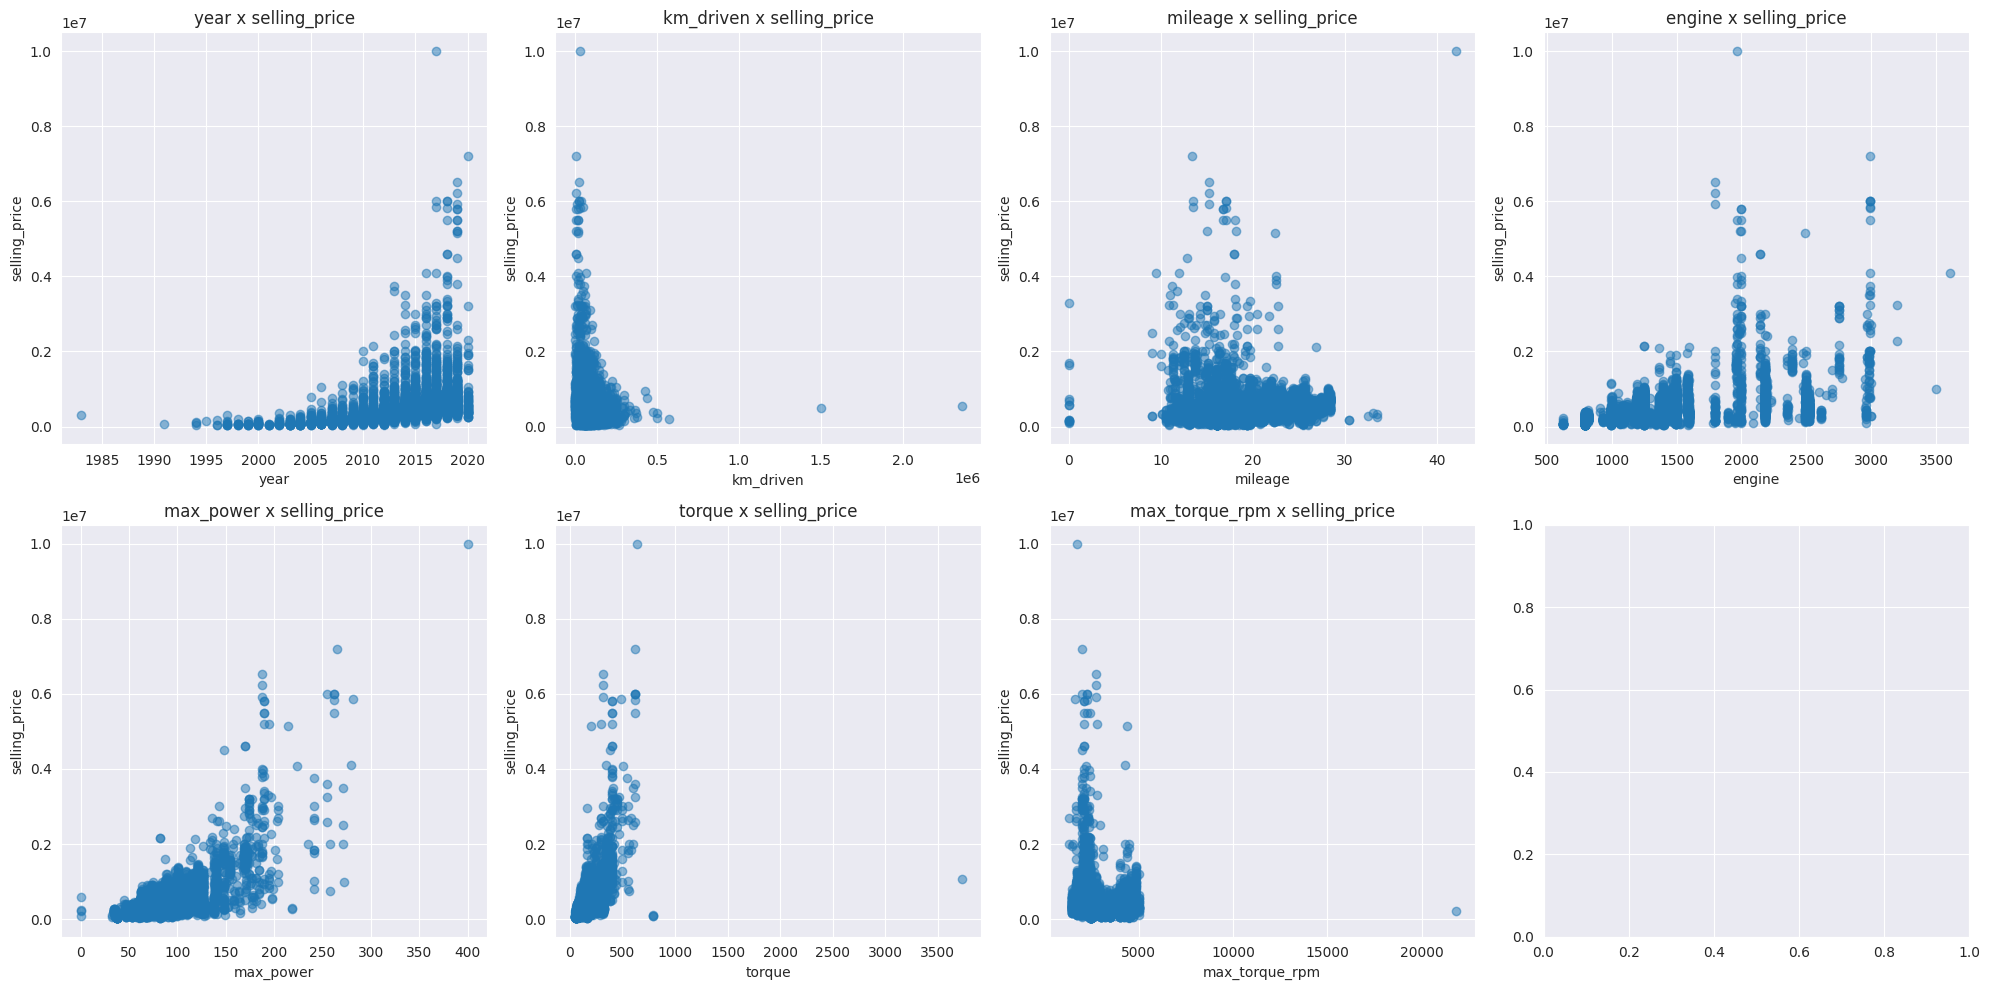

In [289]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, col in enumerate(num_cols):
    row = i // 4
    col_idx = i % 4

    if i < 8:
        axes[row, col_idx].scatter(df_train[col], y_train, alpha=0.5)
        axes[row, col_idx].set_title(f'{col} x selling_price')
        axes[row, col_idx].set_xlabel(col)
        axes[row, col_idx].set_ylabel('selling_price')

plt.tight_layout()
plt.show()

> Зависимость selling_price от year действительно выглядит квадратичной, добавим квадрат года в признаки

In [290]:
X_train_advanced['year_squared'] = df_train['year'] ** 2
X_test_advanced['year_squared'] = df_test['year'] ** 2

Отскейлим наши новые признаки

In [291]:
new_cols = ['year_squared', 'power_per_liter', 'torque_per_liter', 'specific_power']
new_scaler = StandardScaler()

X_train_advanced[new_cols] = new_scaler.fit_transform(X_train_advanced[new_cols])
X_test_advanced[new_cols] = new_scaler.transform(X_test_advanced[new_cols])

In [292]:
X_train_advanced[new_cols].describe()

,year_squared,power_per_liter,torque_per_liter,specific_power
count,5.840000e+03,5.840000e+03,5.840000e+03,5.840000e+03
mean,2.243563e-15,9.246789e-17,6.083414e-17,6.083414e-18
std,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00
min,-7.382651e+00,-6.385907e+00,-3.699593e+00,-2.773134e+01
25%,-5.942571e-01,-3.500452e-01,-3.719973e-01,-2.175063e-02
50%,1.387160e-01,-1.913975e-01,1.270469e-02,-5.953823e-03
75%,8.727818e-01,-5.400162e-02,1.551731e-01,1.358324e-02
max,1.607940e+00,1.180267e+01,1.234588e+01,4.224799e+01


### Пункт 2

In [293]:
X_train_advanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 47 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          5840 non-null   float64
 1   km_driven                     5840 non-null   float64
 2   mileage                       5840 non-null   float64
 3   engine                        5840 non-null   float64
 4   max_power                     5840 non-null   float64
 5   torque                        5840 non-null   float64
 6   max_torque_rpm                5840 non-null   float64
 7   fuel_CNG                      5840 non-null   float64
 8   fuel_Diesel                   5840 non-null   float64
 9   fuel_LPG                      5840 non-null   float64
 10  fuel_Petrol                   5840 non-null   float64
 11  owner_First Owner             5840 non-null   float64
 12  owner_Fourth & Above Owner    5840 non-null   float64
 13  own

> Добавим признак "Третий владелец и более"

In [294]:
X_train_advanced['owner_third_or_more'] = (
    X_train_advanced['owner_Third Owner'] +
    X_train_advanced['owner_Fourth & Above Owner']
).astype(float)

X_test_advanced['owner_third_or_more'] = (
    X_test_advanced['owner_Third Owner'] +
    X_test_advanced['owner_Fourth & Above Owner']
).astype(float)

> Добавим признак "Первый владелец + Официальный дилер"

In [295]:
X_train_advanced['premium_seller_first_owner'] = (
    (X_train_advanced['owner_First Owner'] == 1) &
    (X_train_advanced['seller_type_Trustmark Dealer'] == 1)
).astype(float)

X_test_advanced['premium_seller_first_owner'] = (
    (X_test_advanced['owner_First Owner'] == 1) &
    (X_test_advanced['seller_type_Trustmark Dealer'] == 1)
).astype(float)

Добавим признак "Высокий риск" = много владельцев + частный продавец

In [296]:
X_train_advanced['risk_combination'] = (
    (X_train_advanced['owner_third_or_more'] == 1) &
    (X_train_advanced['seller_type_Individual'] == 1)
).astype(float)

X_test_advanced['risk_combination'] = (
    (X_test_advanced['owner_third_or_more'] == 1) &
    (X_test_advanced['seller_type_Individual'] == 1)
).astype(float)

Добавим признак "Первый владелец + низкий пробег (менее 50000)"

In [297]:
X_train_advanced['low_mileage_first_owner'] = (
    (X_train_advanced['owner_First Owner'] == 1) &
    (X_train_advanced['km_driven'] < 50000)
).astype(float)

X_test_advanced['low_mileage_first_owner'] = (
    (X_test_advanced['owner_First Owner'] == 1) &
    (X_test_advanced['km_driven'] < 50000)
).astype(float)

> Как выжать какую-то другую адекватную информацию из признака name я не придумал ^(

### Пункт 3

> Подумаем, что можно сделать с выбросами. Взглянем еще раз на боксплоты:

In [298]:
num_cols.append(new_cols)

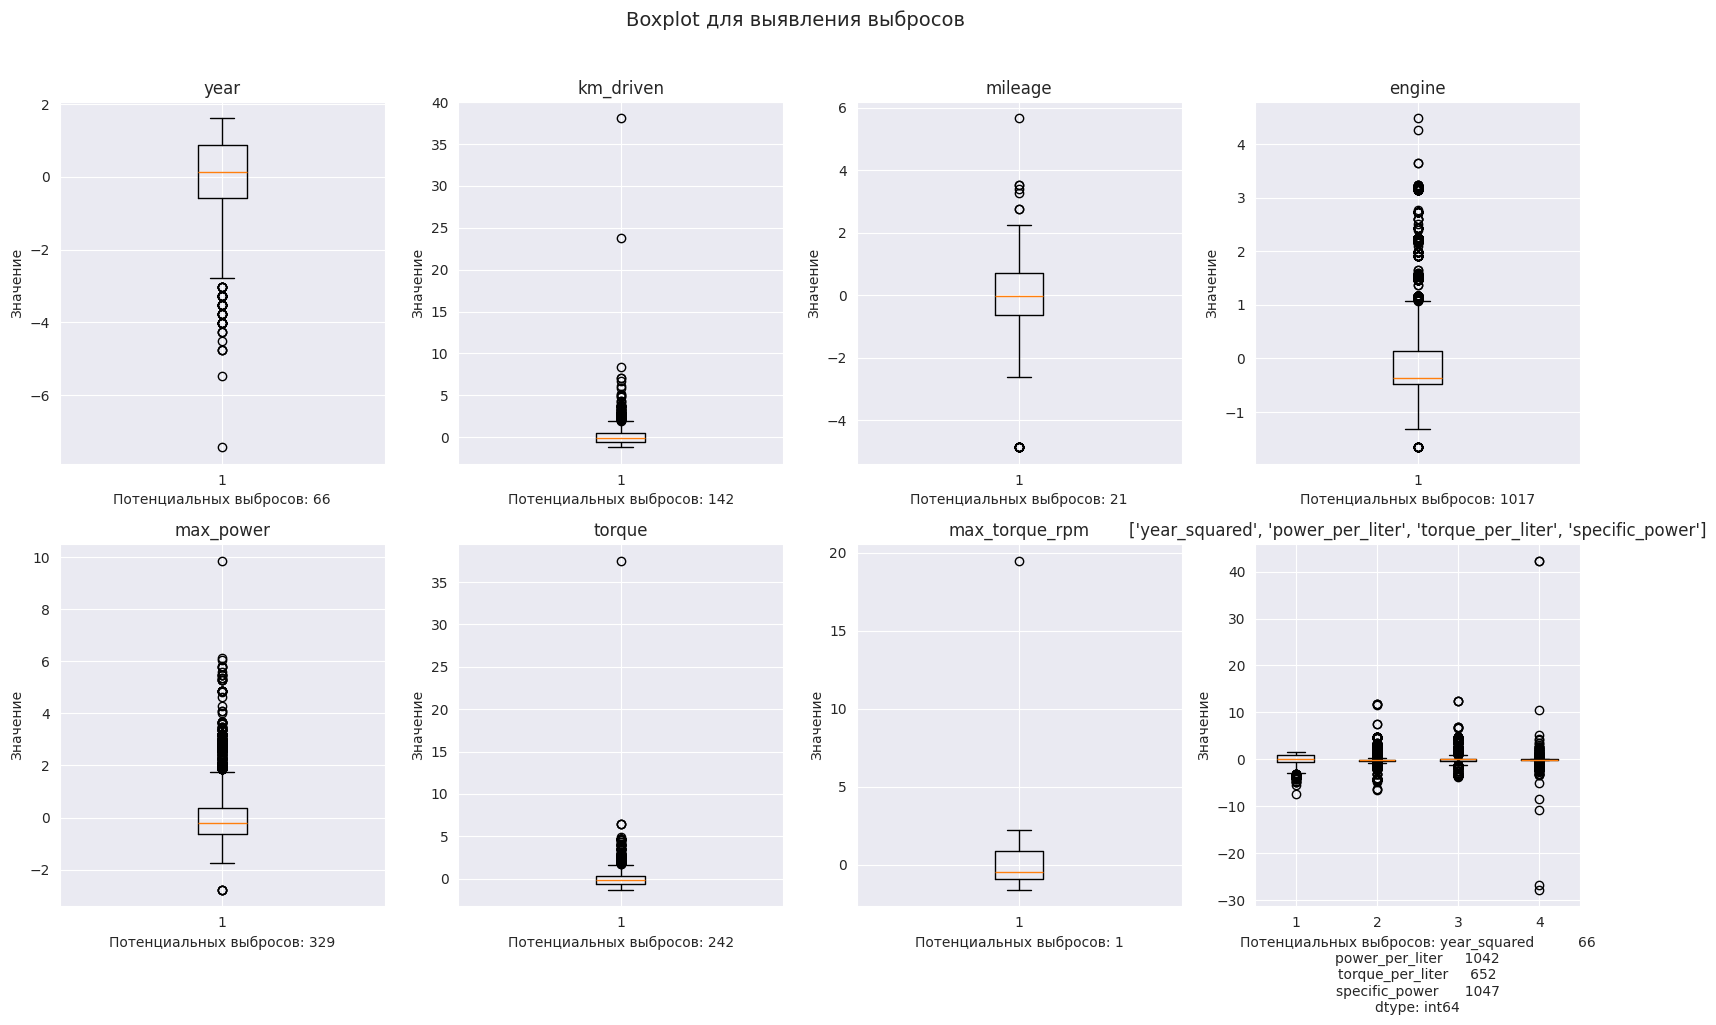

In [299]:
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    axes[i].boxplot(X_train_advanced[col].dropna(), vert=True)
    axes[i].set_title(f'{col}')
    axes[i].set_ylabel('Значение')

    Q1 = X_train_advanced[col].quantile(0.25)
    Q3 = X_train_advanced[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((X_train_advanced[col] < Q1 - 1.5*IQR) | (X_train_advanced[col] > Q3 + 1.5*IQR)).sum()
    axes[i].set_xlabel(f'Потенциальных выбросов: {outliers}')

plt.suptitle('Boxplot для выявления выбросов', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

> Много выбросов наблюдается в следующих колонках:

In [300]:
cols_with_outliers = ['engine', 'power_per_liter', 'specific_power', 'torque_per_liter']

> Тут я долго игрался с тем, как обработать потенциальные выбросы - я пробовал логарифмировать, Робаст скейлить, обрезать хвосты - но модели от этого становились только хуже, либо вообще не сходились

> Так как дедлайн поджимал, решил оставить это в незавершенном виде - но времени в этот пункт убил много...

In [301]:
# from scipy.stats.mstats import winsorize

# limits = (0.05, 0.05)

# for col in cols_with_outliers:
#     X_train_advanced[col] = winsorize(X_train_advanced[col], limits=limits)

# for col in cols_with_outliers:
#     X_test_advanced[col] = winsorize(X_test_advanced[col], limits=limits)

In [302]:
X_train_advanced[cols_with_outliers].describe()

,engine,power_per_liter,specific_power,torque_per_liter
count,5.840000e+03,5.840000e+03,5.840000e+03,5.840000e+03
mean,-1.301851e-16,9.246789e-17,6.083414e-18,6.083414e-17
std,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00
min,-1.658595e+00,-6.385907e+00,-2.773134e+01,-3.699593e+00
25%,-4.786631e-01,-3.500452e-01,-2.175063e-02,-3.719973e-01
50%,-3.736430e-01,-1.913975e-01,-5.953823e-03,1.270469e-02
75%,1.411615e-01,-5.400162e-02,1.358324e-02,1.551731e-01
max,4.477875e+00,1.180267e+01,4.224799e+01,1.234588e+01


> Взглянем на итоговый датасет

In [303]:
new = num_cols.pop(-1)
num_cols.extend(new)
num_cols

['year',
 'km_driven',
 'mileage',
 'engine',
 'max_power',
 'torque',
 'max_torque_rpm',
 'year_squared',
 'power_per_liter',
 'torque_per_liter',
 'specific_power']

In [304]:
X_train_advanced.describe(include='float64')

,year,km_driven,mileage,engine,max_power,torque,max_torque_rpm,fuel_CNG,fuel_Diesel,fuel_LPG,...,brand_Volkswagen,brand_Другое,power_per_liter,torque_per_liter,specific_power,year_squared,owner_third_or_more,premium_seller_first_owner,risk_combination,low_mileage_first_owner
count,5.840000e+03,5.840000e+03,5.840000e+03,5.840000e+03,5.840000e+03,5.840000e+03,5.840000e+03,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5.840000e+03,5.840000e+03,5.840000e+03,5.840000e+03,5840.000000,5840.000000,5840.000000,5840.000000
mean,2.328122e-14,-6.205082e-17,-9.283290e-16,-1.301851e-16,-6.144248e-17,-2.847038e-16,-9.733462e-18,0.008562,0.544007,0.005822,...,0.026199,0.046575,9.246789e-17,6.083414e-17,6.083414e-18,2.243563e-15,0.101712,0.003767,0.101199,0.616952
std,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,0.092140,0.498102,0.076086,...,0.159739,0.210746,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,0.302296,0.061266,0.301617,0.486171
min,-7.430137e+00,-1.231167e+00,-4.875222e+00,-1.658595e+00,-2.776263e+00,-1.315624e+00,-1.591228e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,-6.385907e+00,-3.699593e+00,-2.773134e+01,-7.382651e+00,0.000000,0.000000,0.000000,0.000000
25%,-5.929826e-01,-5.818974e-01,-6.224460e-01,-4.786631e-01,-6.283414e-01,-6.306699e-01,-8.723046e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,-3.500452e-01,-3.719973e-01,-2.175063e-02,-5.942571e-01,0.000000,0.000000,0.000000,0.000000
50%,1.395696e-01,-6.579834e-02,-1.526502e-02,-3.736430e-01,-1.905444e-01,-1.242973e-01,-4.614910e-01,0.000000,1.000000,0.000000,...,0.000000,0.000000,-1.913975e-01,1.270469e-02,-5.953823e-03,1.387160e-01,0.000000,0.000000,0.000000,1.000000
75%,8.721218e-01,4.336523e-01,7.198756e-01,1.411615e-01,3.508581e-01,2.976799e-01,9.250050e-01,0.000000,1.000000,0.000000,...,0.000000,0.000000,-5.400162e-02,1.551731e-01,1.358324e-02,8.727818e-01,0.000000,0.000000,0.000000,1.000000
max,1.604674e+00,3.806654e+01,5.662630e+00,4.477875e+00,9.858570e+00,3.750053e+01,1.946297e+01,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.180267e+01,1.234588e+01,4.224799e+01,1.607940e+00,1.000000,1.000000,1.000000,1.000000


In [305]:
X_test_advanced.describe()

,year,km_driven,mileage,engine,max_power,torque,max_torque_rpm,fuel_CNG,fuel_Diesel,fuel_LPG,...,brand_Volkswagen,brand_Другое,power_per_liter,torque_per_liter,specific_power,year_squared,owner_third_or_more,premium_seller_first_owner,risk_combination,low_mileage_first_owner
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.061675,-0.042602,-0.023091,0.052360,0.093160,0.032456,0.047498,0.005000,0.534000,0.004000,...,0.0,0.097000,-0.023557,-0.019381,2.581502,0.061701,0.098000,0.025000,0.097000,0.623000
std,0.979703,0.807216,0.991499,1.074903,1.102180,0.927469,0.980920,0.070569,0.499092,0.063151,...,0.0,0.296106,0.888231,1.000549,82.364794,0.979845,0.297463,0.156203,0.296106,0.484877
min,-4.499928,-1.209490,-4.875222,-1.658595,-1.695985,-1.305833,-1.416633,0.000000,0.000000,0.000000,...,0.0,0.000000,-4.391781,-3.241777,-10.723948,-4.484994,0.000000,0.000000,0.000000,0.000000
25%,-0.592983,-0.615194,-0.722807,-0.478663,-0.596754,-0.632824,-0.743925,0.000000,0.000000,0.000000,...,0.0,0.000000,-0.368266,-0.357343,-0.023840,-0.594257,0.000000,0.000000,0.000000,0.000000
50%,0.139570,-0.207309,-0.015265,-0.373643,-0.172698,-0.124297,-0.461491,0.000000,1.000000,0.000000,...,0.0,0.000000,-0.199770,0.012705,-0.004671,0.138716,0.000000,0.000000,0.000000,1.000000
75%,0.872122,0.433652,0.719876,0.314136,0.445619,0.350427,1.181763,0.000000,1.000000,0.000000,...,0.0,0.000000,-0.058721,0.174498,0.014933,0.872782,0.000000,0.000000,0.000000,1.000000
max,1.604674,5.011950,3.218852,4.477875,6.068120,4.728440,2.208797,1.000000,1.000000,1.000000,...,0.0,1.000000,4.800629,4.847719,2604.529304,1.607940,1.000000,1.000000,1.000000,1.000000


> Обучим модельки на датасете с новым признаками и замерим качество!

In [306]:
def grid_search(model, params, scoring, name):
  grid = GridSearchCV(
      estimator=model,
      param_grid=params,
      cv=10,
      scoring=scoring
  )

  grid.fit(X_train_advanced, y_train)

  print(f'\nРезультаты для {name}\n')

  print("Лучшие гиперпараметры:", grid.best_params_)
  print("Лучшая метрика на кросс-валидации:", grid.best_score_)

  return grid.best_estimator_

In [307]:
linreg_advanced = grid_search(model=LinearRegression(),
                              params={},
                              scoring='r2',
                              name='Линейная регрессия')

# Ridge
ridge_advanced = grid_search(model=Ridge(),
                            params={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
                            scoring='r2',
                            name='Ridge')

# Lasso
lasso_advanced = grid_search(model=Lasso(max_iter=10000),
                            params={'alpha': [1000, 1500, 1750, 1790, 1800, 1850, 2000]},
                            scoring='r2',
                            name='Lasso')

# ElasticNet
elastic_advanced = grid_search(model=ElasticNet(max_iter=10000),
                              params={
                                  'alpha': [0.01, 0.1, 1.0],
                                  'l1_ratio': [0.5, 0.6, 0.7, 0.9]
                              },
                              scoring='r2',
                              name='ElasticNEt')


Результаты для Линейная регрессия

Лучшие гиперпараметры: {}
Лучшая метрика на кросс-валидации: 0.6649998638857151

Результаты для Ridge

Лучшие гиперпараметры: {'alpha': 0.0001}
Лучшая метрика на кросс-валидации: 0.6649660329478048

Результаты для Lasso

Лучшие гиперпараметры: {'alpha': 2000}
Лучшая метрика на кросс-валидации: 0.6574175177145513

Результаты для ElasticNEt

Лучшие гиперпараметры: {'alpha': 0.01, 'l1_ratio': 0.7}
Лучшая метрика на кросс-валидации: 0.6520675510520488


In [308]:
results = []

# Линейная регрессия
y_pred_linreg_advanced = linreg_advanced.predict(X_test_advanced)
mse_linreg_advanced = MSE(y_test, y_pred_linreg_advanced)
r2_linreg_advanced = r2_score(y_test, y_pred_linreg_advanced)
results.append({
    'Модель': 'Линейная регрессия',
    'R²': r2_linreg_advanced,
    'MSE': mse_linreg_advanced
})

# Ridge
y_pred_ridge_advanced = ridge_advanced.predict(X_test_advanced)
mse_ridge_advanced = MSE(y_test, y_pred_ridge_advanced)
r2_ridge_advanced = r2_score(y_test, y_pred_ridge_advanced)
results.append({
    'Модель': 'Ridge',
    'R²': r2_ridge_advanced,
    'MSE': mse_ridge_advanced
})

# Lasso
y_pred_lasso_advanced = lasso_advanced.predict(X_test_advanced)
mse_lasso_advanced = MSE(y_test, y_pred_lasso_advanced)
r2_lasso_advanced = r2_score(y_test, y_pred_lasso_advanced)
results.append({
    'Модель': 'Lasso',
    'R²': r2_lasso_advanced,
    'MSE': mse_lasso_advanced
})

# ElasticNet
y_pred_elastic_advanced = elastic_advanced.predict(X_test_advanced)
mse_elastic_advanced = MSE(y_test, y_pred_elastic_advanced)
r2_elastic_advanced = r2_score(y_test, y_pred_elastic_advanced)
results.append({
    'Модель': 'ElasticNet',
    'R²': r2_elastic_advanced,
    'MSE': mse_elastic_advanced
})

results_df_advanced = pd.DataFrame(results)
results_df_advanced = results_df_advanced.sort_values('MSE')
results_df_advanced

,Модель,R²,MSE
2,Lasso,0.688386,1.791245e+11
3,ElasticNet,0.663144,1.936343e+11
1,Ridge,0.618915,2.190583e+11
0,Линейная регрессия,0.617712,2.197498e+11


> Лучше всего себя показывает по обеим метрикам Lasso!

In [309]:
lasso_advanced.intercept_, lasso_advanced.coef_

(np.float64(451744.93796437705),
 array([ 0.00000000e+00, -3.12802733e+04,  2.75759918e+03,  2.16113847e+04,
         2.50107195e+05,  2.51308155e+04, -4.53826685e+04, -0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.05991031e+02,
        -0.00000000e+00, -4.14697535e+04,  1.88682535e+05, -0.00000000e+00,
         0.00000000e+00,  3.61585562e+05, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -0.00000000e+00,  7.54286212e+04, -6.32209433e+03, -0.00000000e+00,
         1.90362652e+05, -5.54137043e-08, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00,  1.63590168e+04, -0.00000000e+00,  9.85788865e+04,
        -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -6.63737157e+04,
         2.00800204e+05, -1.50756779e+04,  4.85029096e+05,  2.75985420e+03,
        -0.00000000e+00, -3.19988823e+02,  1.62924668e+05, -0.00000000e+00,
         0.00000000e+00, -1.72684357e+04,  0.00000000e+

> Заметим, что много весов занулилось :)

# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса

In [310]:
def business_metric(y_true, y_pred):
    absolute_percentage_error = np.abs((y_true - y_pred) / y_true)

    within_tolerance = absolute_percentage_error <= 0.1
    proportion = np.mean(within_tolerance)

    return proportion

In [311]:
results = []

# Линейная регрессия
y_pred_linreg_advanced = linreg_advanced.predict(X_test_advanced)
mse_linreg_advanced = MSE(y_test, y_pred_linreg_advanced)
r2_linreg_advanced = r2_score(y_test, y_pred_linreg_advanced)
business_metric_linreg = business_metric(y_test, y_pred_linreg_advanced)
results.append({
    'Модель': 'Линейная регрессия',
    'R²': r2_linreg_advanced,
    'MSE': mse_linreg_advanced,
    'Business Metric': business_metric_linreg
})

# Ridge
y_pred_ridge_advanced = ridge_advanced.predict(X_test_advanced)
mse_ridge_advanced = MSE(y_test, y_pred_ridge_advanced)
r2_ridge_advanced = r2_score(y_test, y_pred_ridge_advanced)
business_metric_ridge = business_metric(y_test, y_pred_ridge_advanced)
results.append({
    'Модель': 'Ridge',
    'R²': r2_ridge_advanced,
    'MSE': mse_ridge_advanced,
    'Business Metric': business_metric_ridge
})

# Lasso
y_pred_lasso_advanced = lasso_advanced.predict(X_test_advanced)
mse_lasso_advanced = MSE(y_test, y_pred_lasso_advanced)
r2_lasso_advanced = r2_score(y_test, y_pred_lasso_advanced)
business_metric_lasso = business_metric(y_test, y_pred_lasso_advanced)
results.append({
    'Модель': 'Lasso',
    'R²': r2_lasso_advanced,
    'MSE': mse_lasso_advanced,
    'Business Metric': business_metric_lasso
})

# ElasticNet
y_pred_elastic_advanced = elastic_advanced.predict(X_test_advanced)
mse_elastic_advanced = MSE(y_test, y_pred_elastic_advanced)
r2_elastic_advanced = r2_score(y_test, y_pred_elastic_advanced)
business_metric_elastic = business_metric(y_test, y_pred_elastic_advanced)
results.append({
    'Модель': 'ElasticNet',
    'R²': r2_elastic_advanced,
    'MSE': mse_elastic_advanced,
    'Business Metric': business_metric_elastic
})

results_df_advanced = pd.DataFrame(results)
results_df_advanced = results_df_advanced.sort_values('Business Metric', ascending=False)
results_df_advanced

,Модель,R²,MSE,Business Metric
2,Lasso,0.688386,1.791245e+11,0.241
1,Ridge,0.618915,2.190583e+11,0.240
0,Линейная регрессия,0.617712,2.197498e+11,0.237
3,ElasticNet,0.663144,1.936343e+11,0.234


### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [ ] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



> В зависимости от того, продаем мы или покупаем машины, превышение или недобор цены в прогнозе могут иметь для нас разную значимость

> Сделаем метрику с двумя параметрами alpha и beta, которые определяют коридор между перепрогнозом и недопрогнозом

In [312]:
def your_business_metrics(y_true, y_pred, alpha=0.4, beta=0.1):
    percentage_error = (y_pred - y_true) / y_true

    overprediction = alpha
    underprediction = beta

    acceptable = (
        (percentage_error <= overprediction) &
        (percentage_error >= -underprediction)
    )

    proportion = np.mean(acceptable)
    return proportion

> Допустим, для нас недопрогноз в разы страшнее перепрогноза - alpha = 0.4, beta = 0.1 (перепрогноз до 30% - ок, но недопрогноз только до 10% - ок)

In [313]:
results_custom = []

# Линейная регрессия
y_pred_linreg_advanced = linreg_advanced.predict(X_test_advanced)
business_metric_linreg = your_business_metrics(y_test, y_pred_linreg_advanced)
results_custom.append({
    'Модель': 'Линейная регрессия',
    'Custom business Metric': business_metric_linreg
})

# Ridge
y_pred_ridge_advanced = ridge_advanced.predict(X_test_advanced)
business_metric_ridge = your_business_metrics(y_test, y_pred_ridge_advanced)
results_custom.append({
    'Модель': 'Ridge',
    'Custom business Metric': business_metric_ridge
})

# Lasso
y_pred_lasso_advanced = lasso_advanced.predict(X_test_advanced)
business_metric_lasso = your_business_metrics(y_test, y_pred_lasso_advanced)
results_custom.append({
    'Модель': 'Lasso',
    'Custom business Metric': business_metric_lasso
})

# ElasticNet
y_pred_elastic_advanced = elastic_advanced.predict(X_test_advanced)
business_metric_elastic = your_business_metrics(y_test, y_pred_elastic_advanced)
results_custom.append({
    'Модель': 'ElasticNet',
    'Custom business Metric': business_metric_elastic
})

results_custom_df = pd.DataFrame(results_custom)
results_custom_df = results_custom_df.sort_values('Custom business Metric', ascending=False)
results_custom_df

,Модель,Custom business Metric
2,Lasso,0.429
3,ElasticNet,0.412
1,Ridge,0.406
0,Линейная регрессия,0.406


> Lasso тут работает лучше всех остальных

> Значения метрики сомнительное, но окэээй. Имеем что имеем...

# **Часть 6 (1 балл) | Оформление результатов**

### **Задание 25**

**Результаты вашей работы** необходимо разместить в своем Гитхабе. Далее в этот же репозиторий вы прикрепите вторую часть. Под результатами первой части понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)

In [314]:
import pickle
import datetime

artifacts = {
        'timestamp': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'best_model': lasso_advanced,
        'scaler': scaler,
        'new_scaler': new_scaler,
        'ohe_encoder': ohe,
        'feature_names': X_train_advanced.columns.tolist(),
        'model_metrics': {
            'best_model_name': 'Lasso',
            'test_r2': r2_lasso_advanced,
            'test_mse': mse_lasso_advanced,
            'business_metric': business_metric_lasso
        }
    }

with open('model.pkl', 'wb') as f:
  pickle.dump(artifacts, f)

https://github.com/notglebatall/ML_homework/